In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
from skimage.morphology import remove_small_holes,remove_small_objects,binary_closing,closing,convex_hull_image
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
orig_img_shape = (640,640)
img_shape = (640,640)
def image_segmentation(img):

    # Transform the input image to YCbCr color space and calculate the histogram and its first derivative of cr-component
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_cr = img_ycrcb[:,:,1]
    cr_hist,_ = np.histogram(img_cr.ravel(),256,[0,256])
    cr_hist_diff = np.diff(cr_hist)

    # Transform the input image to CIE-Lab color space and calculate the histogram and its first derivative of a-component
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img_a = img_lab[:,:,1]
    a_hist,_ = np.histogram(img_a.ravel(),256,[0,256])
    a_hist_diff = np.diff(a_hist)

    int_lvls = np.arange(0,255)

    # Calculating the segmentation threshold for cr-component based on its difference histogram

    # -18000 is the threshold of cr-component for (1200x900) image.
    cr_hist_th = int(-18000*(orig_img_shape[0]*orig_img_shape[1])/(2988*3984))
    if (int_lvls[cr_hist_diff<=cr_hist_th].size!=0):
        cr_th_i = np.max(int_lvls[cr_hist_diff<=cr_hist_th])

    else:
        cr_th_i = np.argmax(cr_hist)

    # Calculating the segmentation threshold for a-component based on its difference histogram

    # -1000 is the threshold of a-component for (1200x900) image. So scaling the threshold as per input image dimensions
    a_hist_th = int(-1000*(orig_img_shape[0]*orig_img_shape[1])/(2988*3984))
    if (int_lvls[a_hist_diff<=a_hist_th].size!=0):
        a_th_i = np.max(int_lvls[a_hist_diff<=a_hist_th])
    # If there is no pixel intensity below -1000, take threshold as peak of a-histogram
    else:
        a_th_i = np.argmax(a_hist)


    # Thresholding the cr and a components using the above thresholds and calculating their segmented image outputs
    a_th = a_th_i
    cr_th = cr_th_i
    _, img_a_th = cv2.threshold(img_a, a_th, 255, cv2.THRESH_BINARY)
    _, img_cr_th = cv2.threshold(img_cr, cr_th, 255, cv2.THRESH_BINARY)

    # Performing logical AND between both the segmented images to get the final segmented image
    img_seg = cv2.bitwise_and(img_cr_th,img_a_th)

    return img_seg

In [5]:
# Function definition of image postprocessing to remove small size artifacts from segmented image

def image_postprocess(img_seg):

    # Removing small size artifacts on segmented image
    img_bin1 = (img_seg//255).astype(bool)
    img_rem1 = remove_small_objects(img_bin1,min_size=20,connectivity=8).astype('uint8')*255
    #img_fill = (remove_small_holes(img_rem1,area_threshold=5000,connectivity=8)).astype('uint8')*255
    #img_bin2 = (img_fill//255).astype(bool)
    #img_rem2 = remove_small_objects(img_bin2,min_size=50,connectivity=8).astype('uint8')*255
    img_pp = img_rem1.copy()

    return img_pp

In [6]:
main_fold = "/content/drive/MyDrive/tuberculosis_new_final/train"
# main_fold = "/content/drive/MyDrive/tuberculosis_microscpic_images/Overlapping_Microscope-3_set6"
output_dir = "/content/drive/MyDrive/tuberculosis_new_final/mask/train"
# annot_fold_path = "/content/drive/MyDrive/tuberculosis/train/_annotations.csv"

In [ ]:
# !pip install tensorflow
# from tensorflow.keras.preprocessing import image

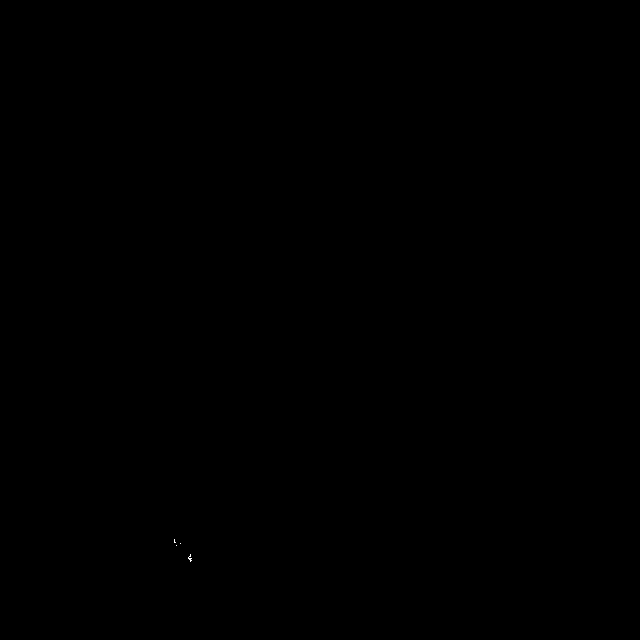

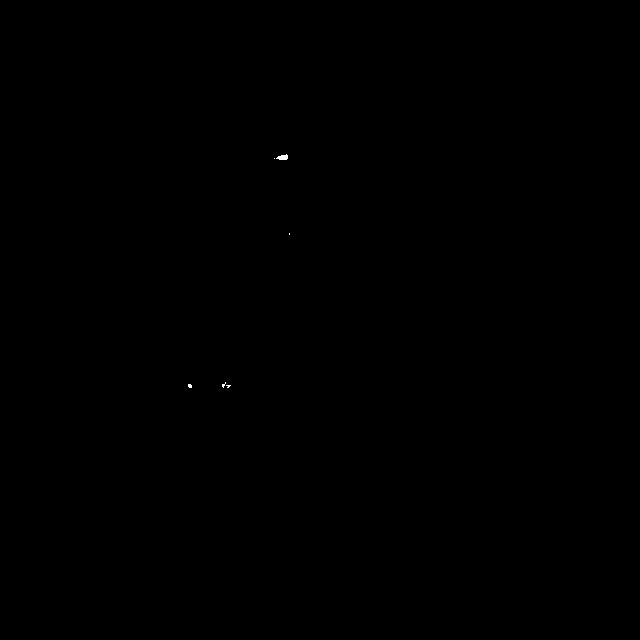

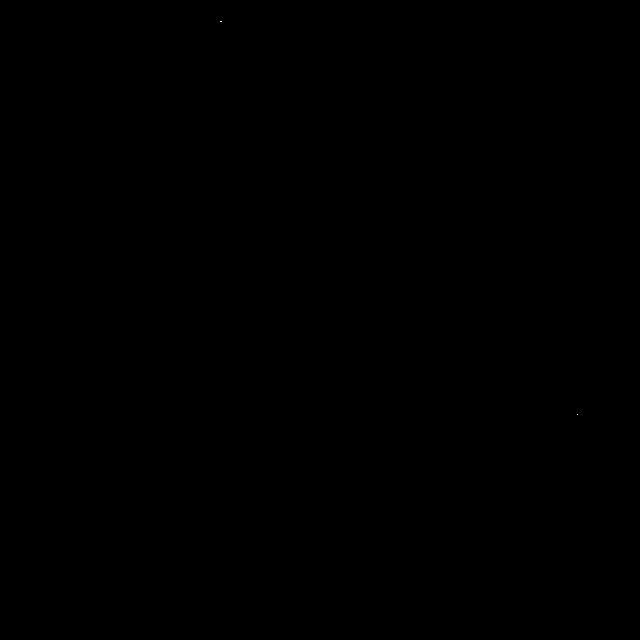

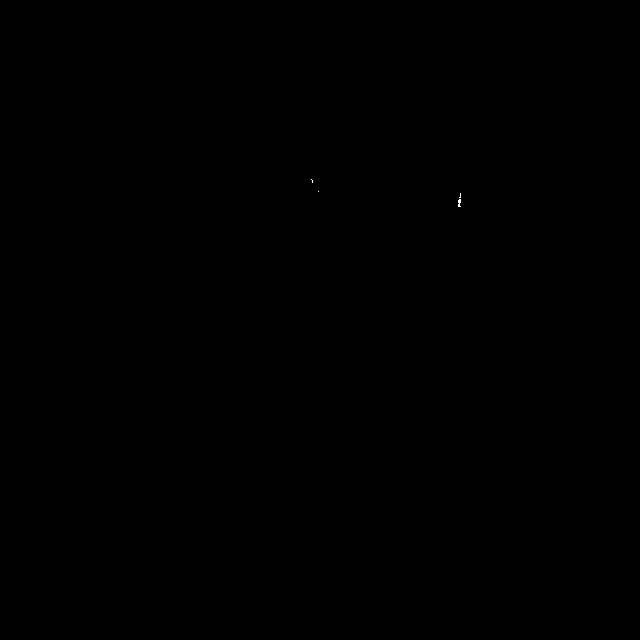

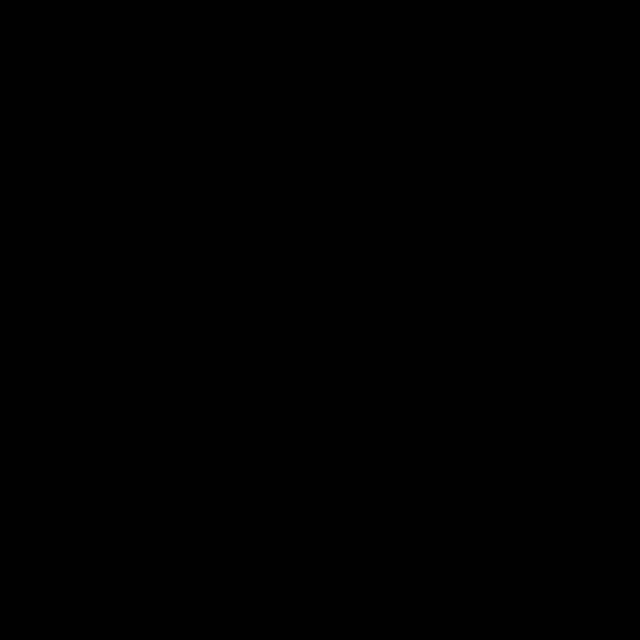

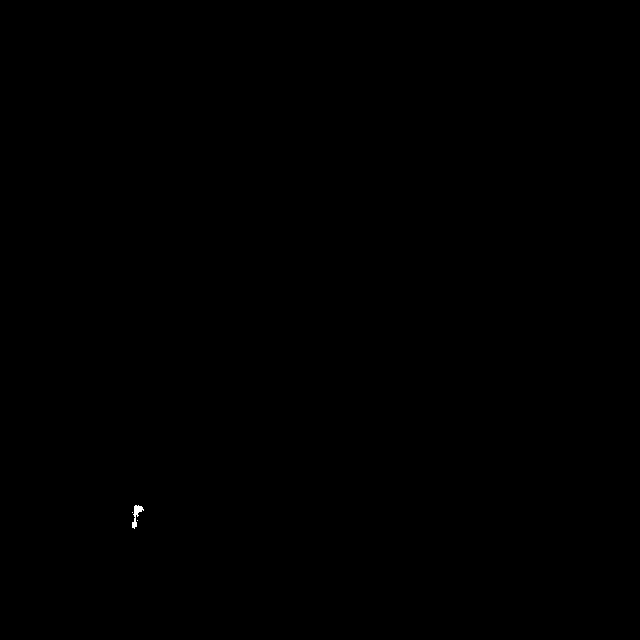

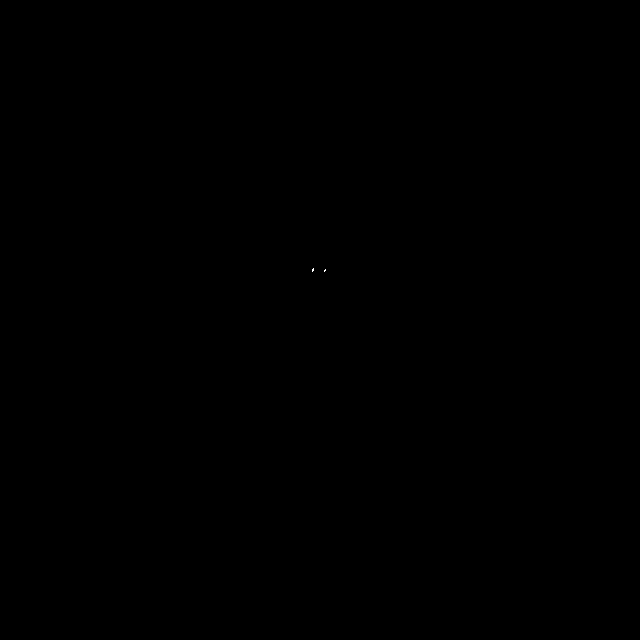

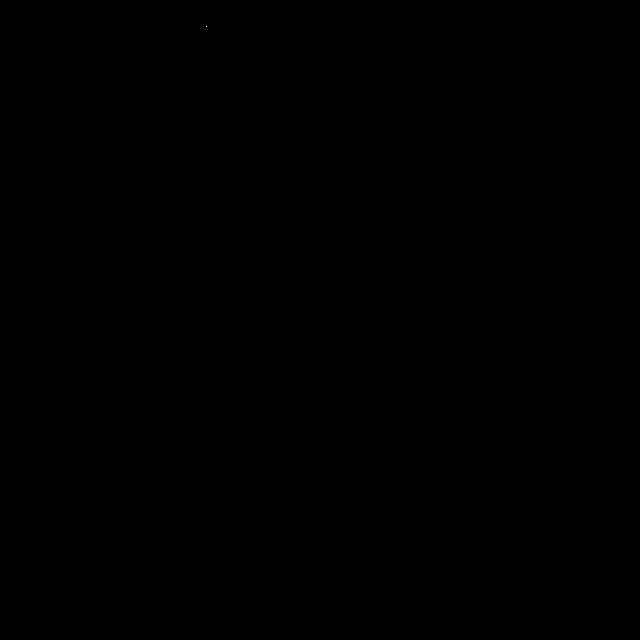

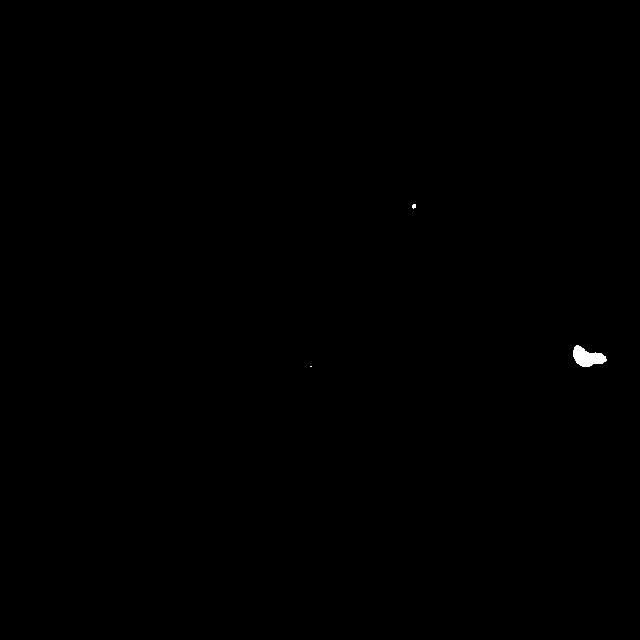

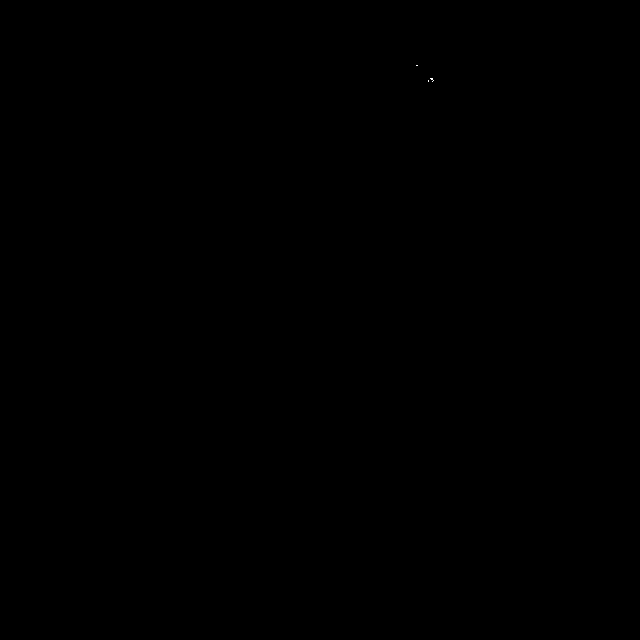

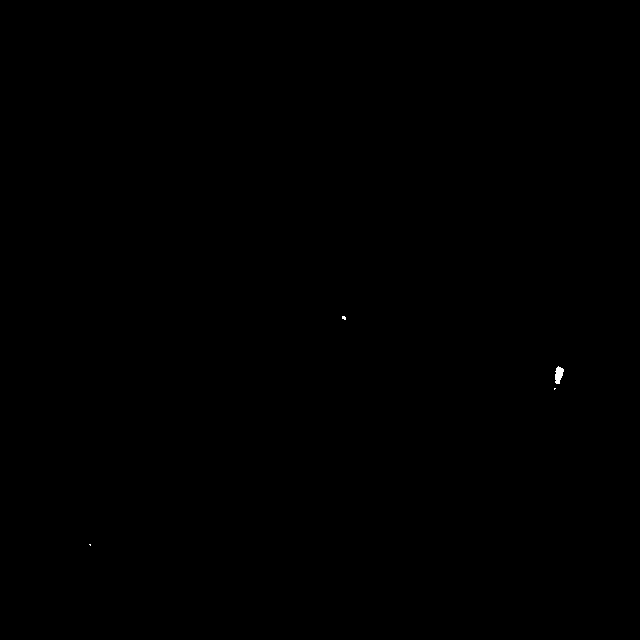

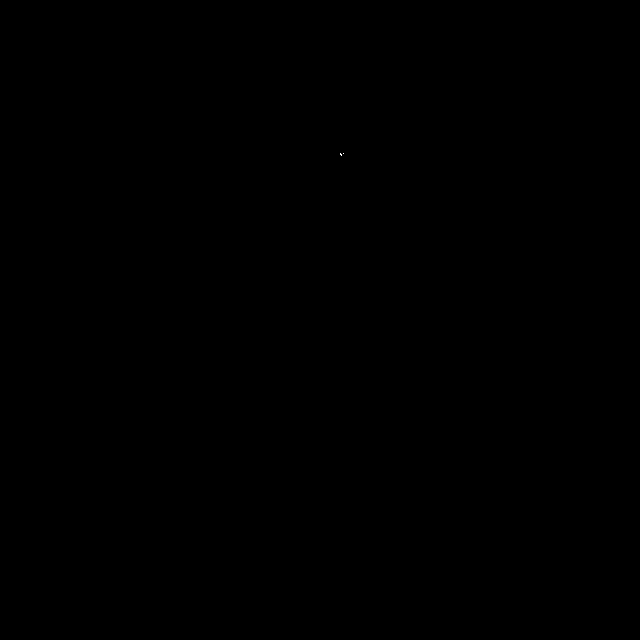

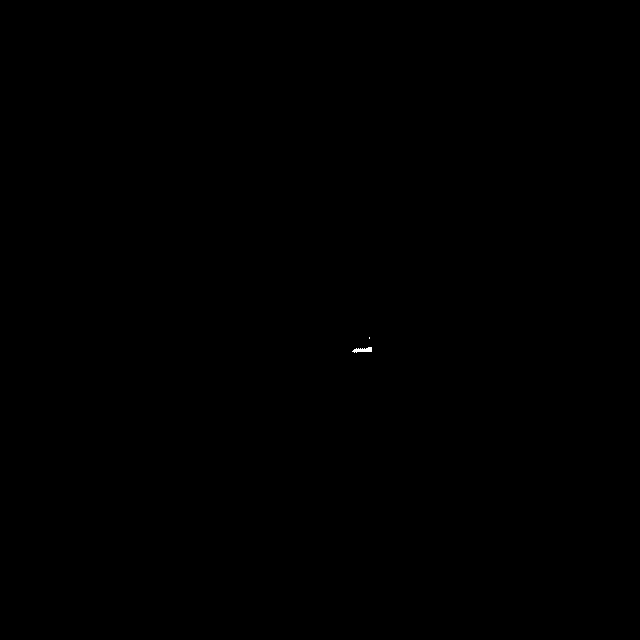

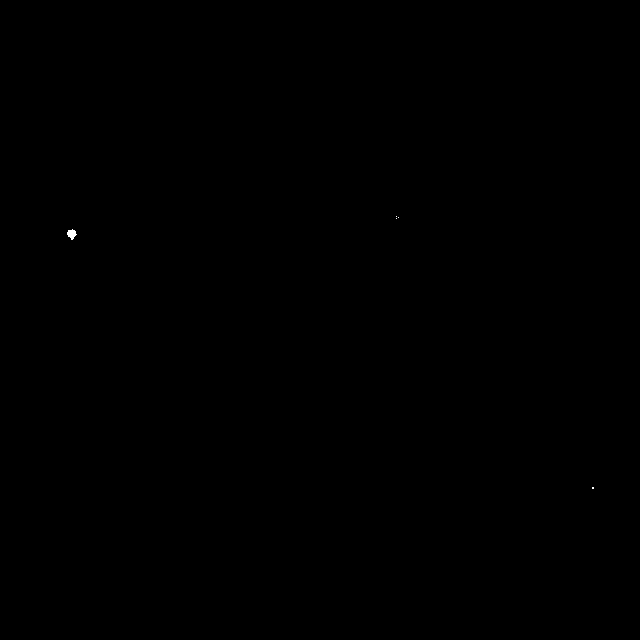

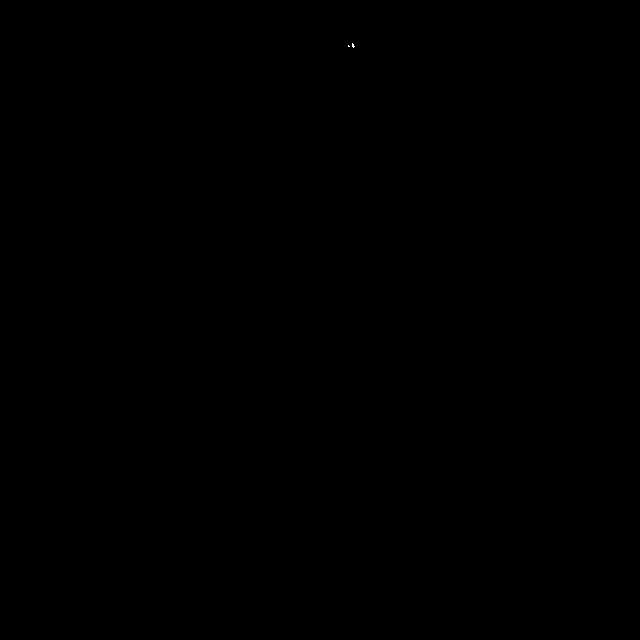

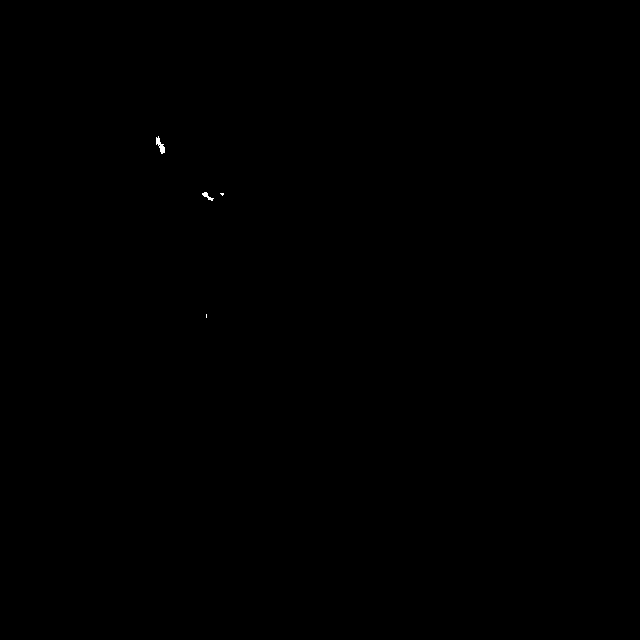

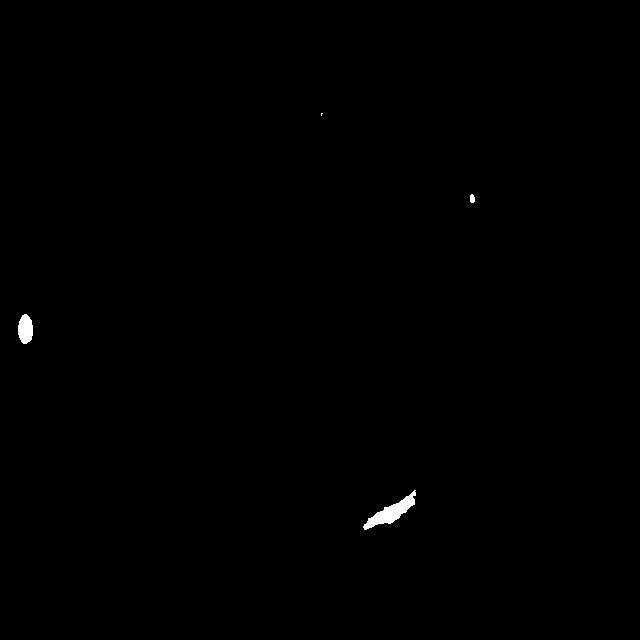

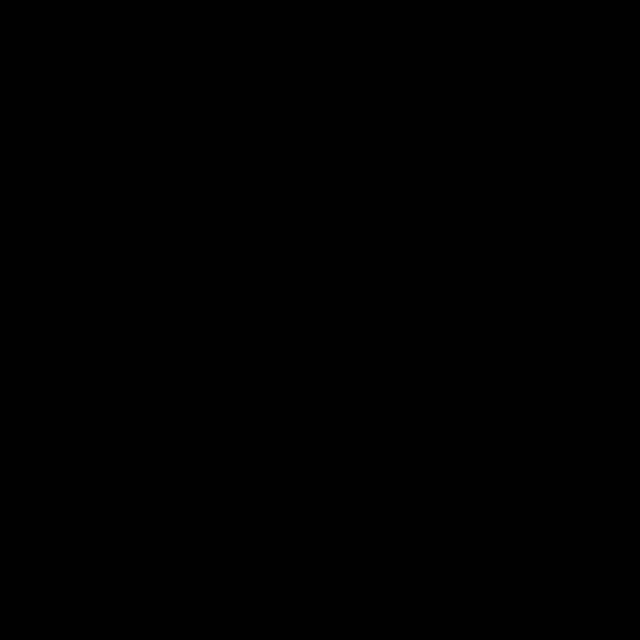

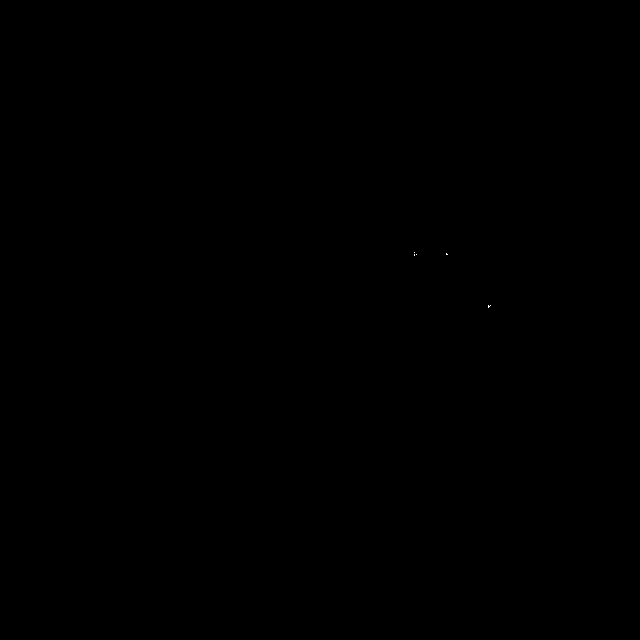

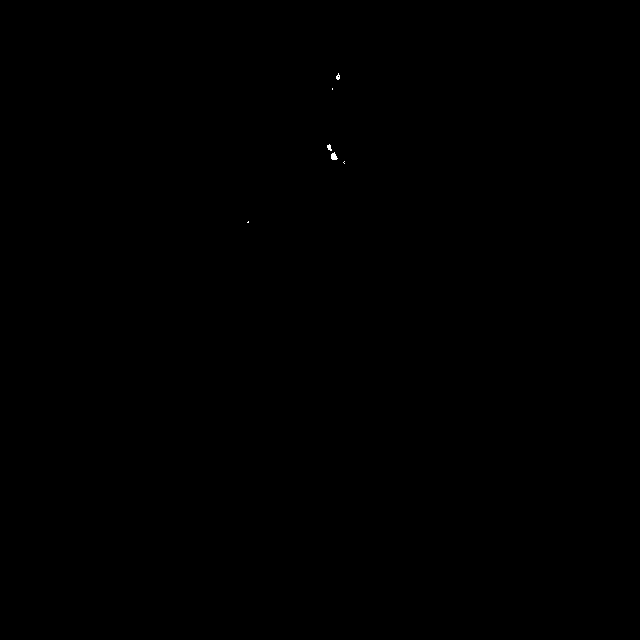

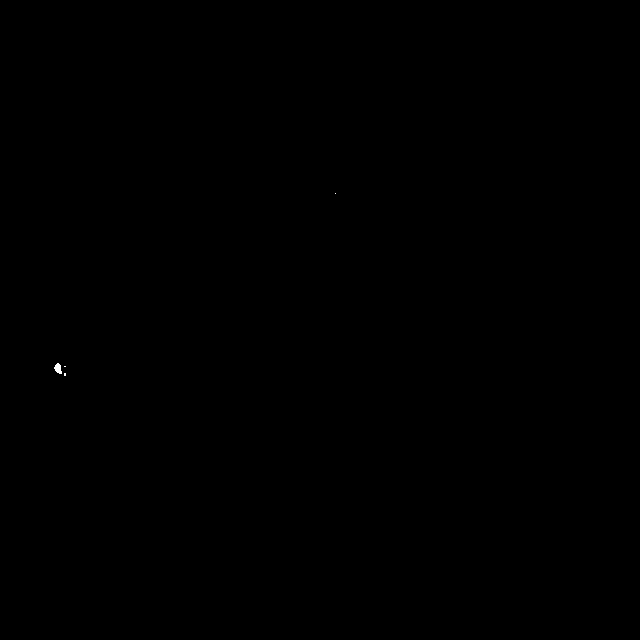

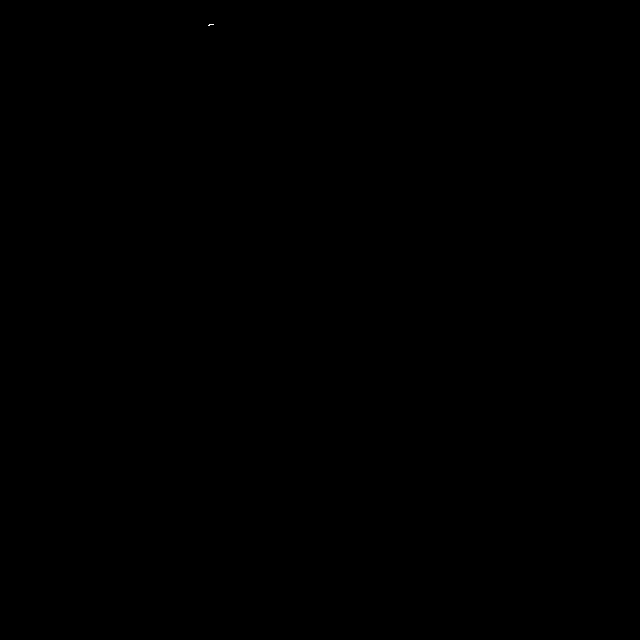

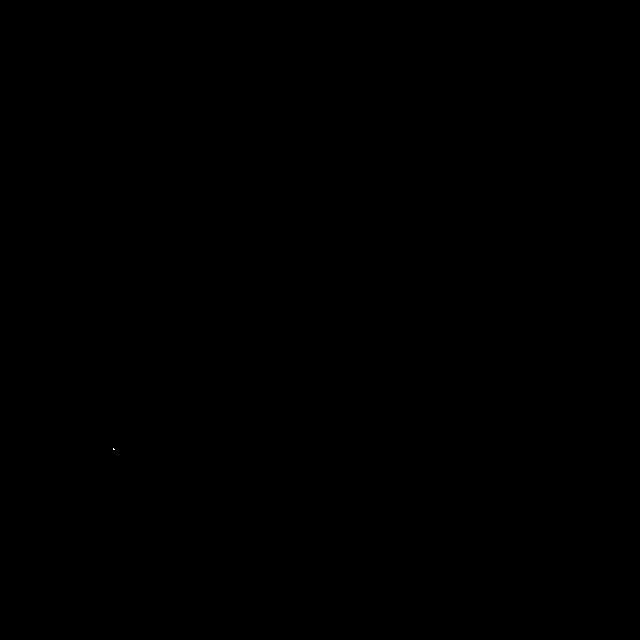

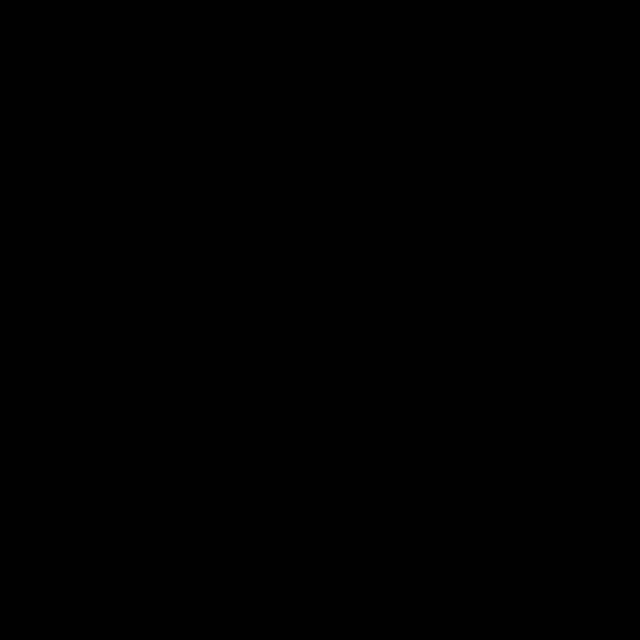

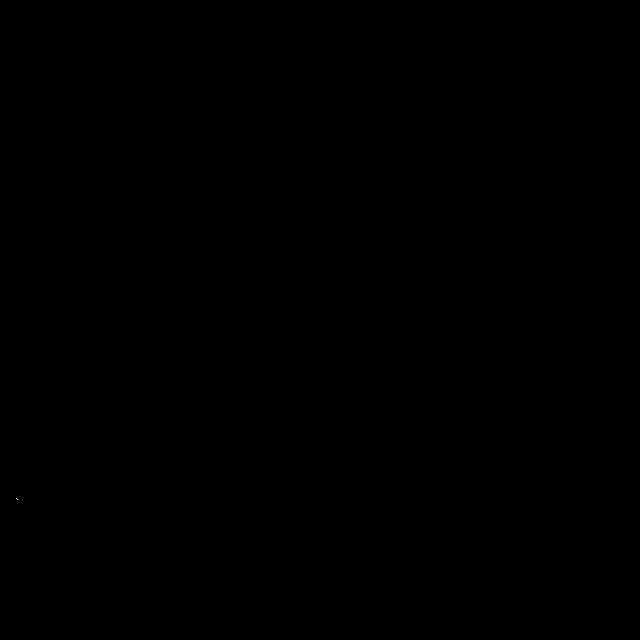

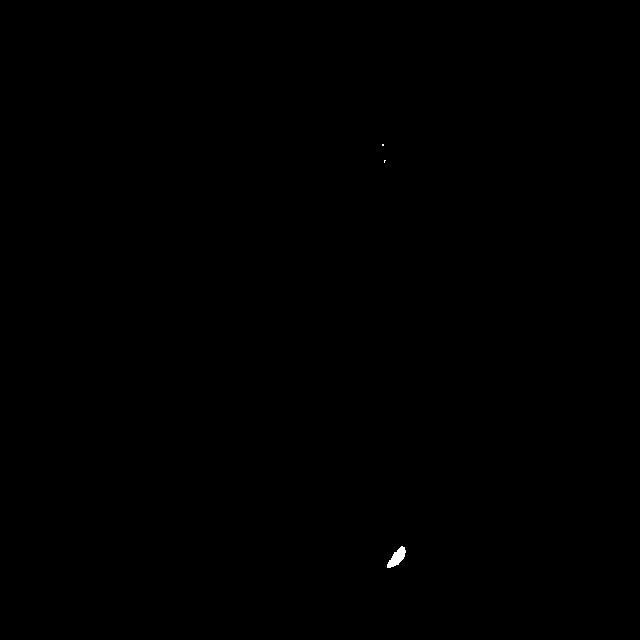

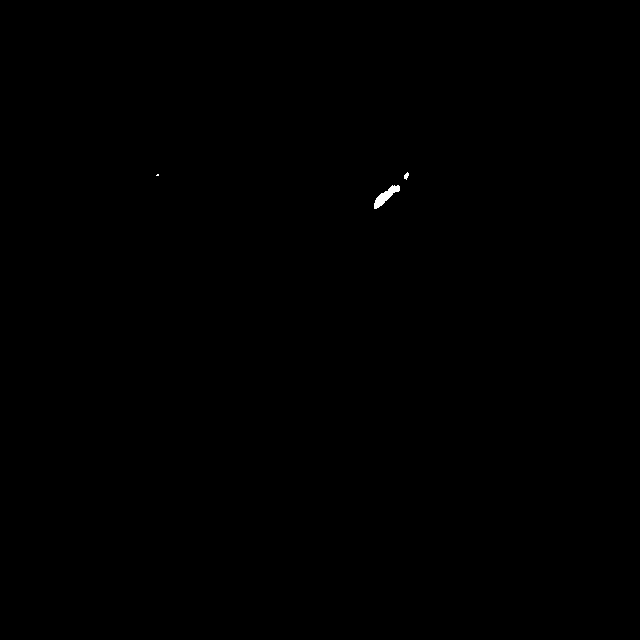

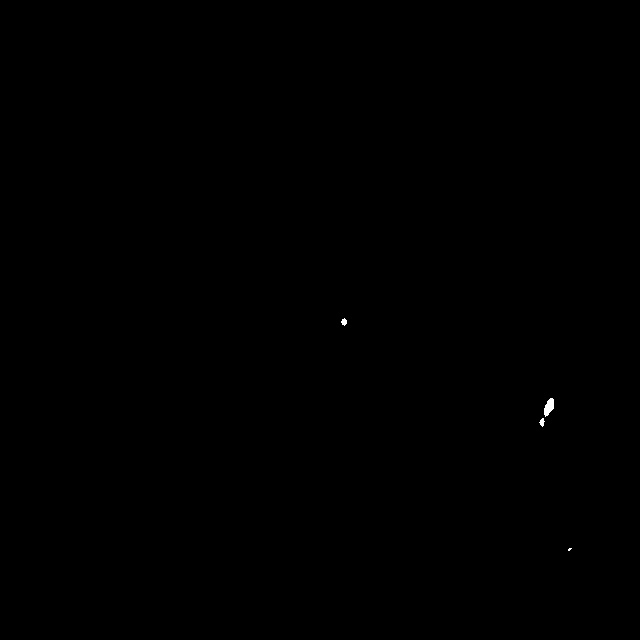

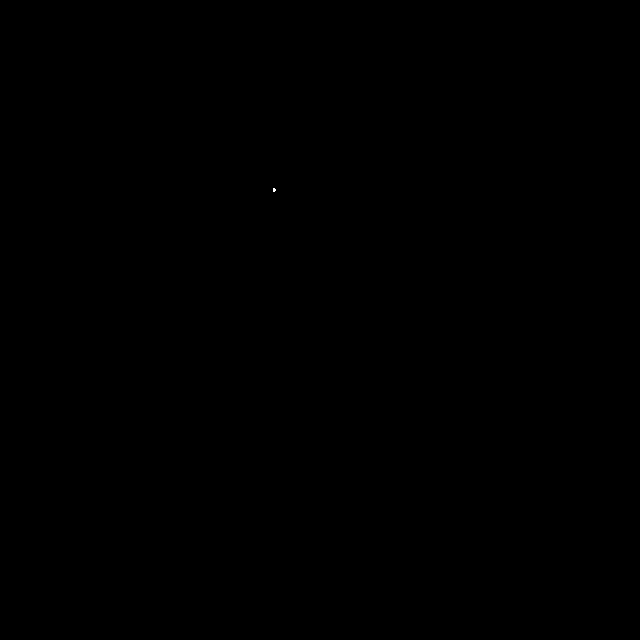

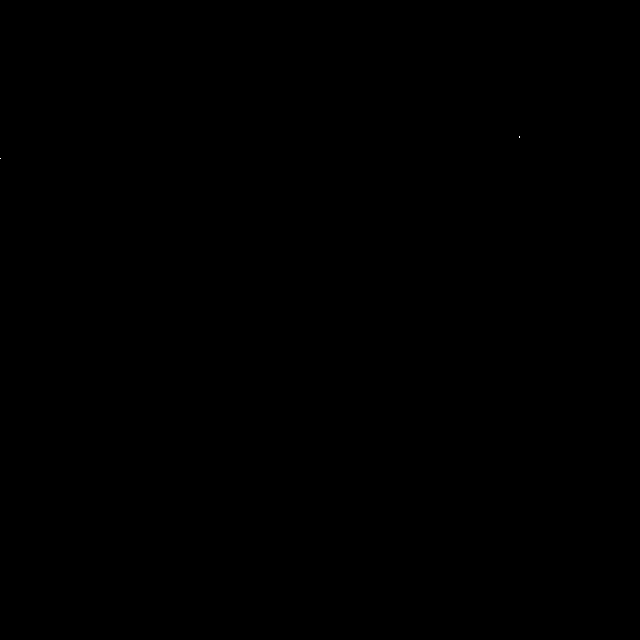

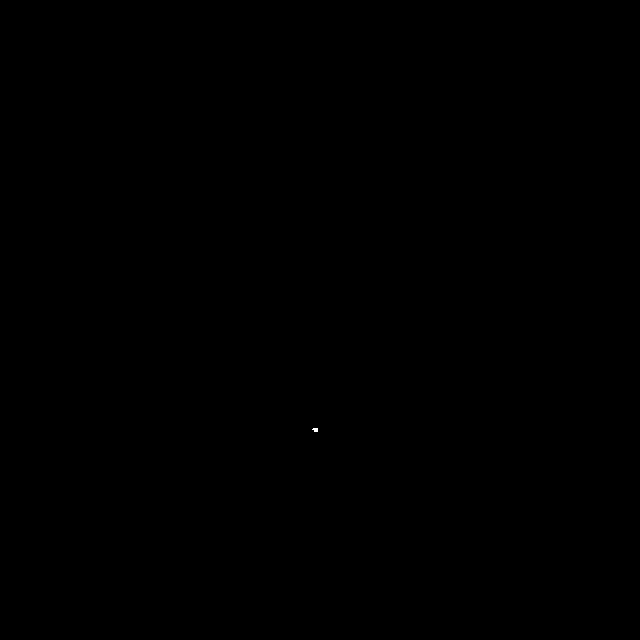

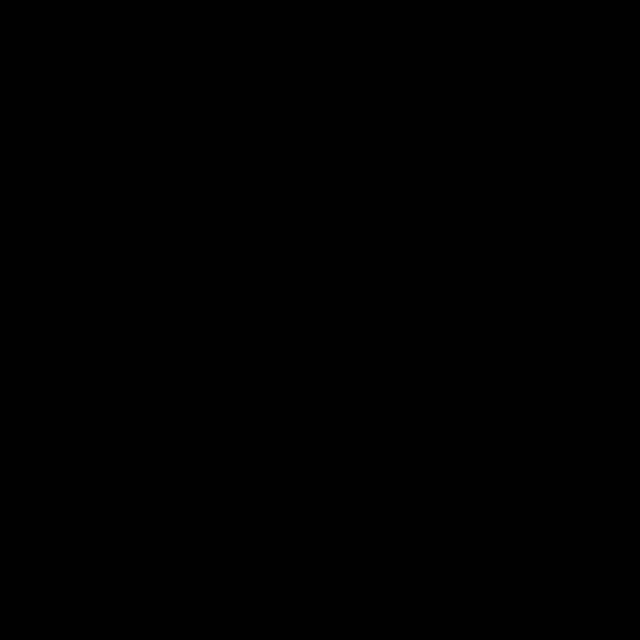

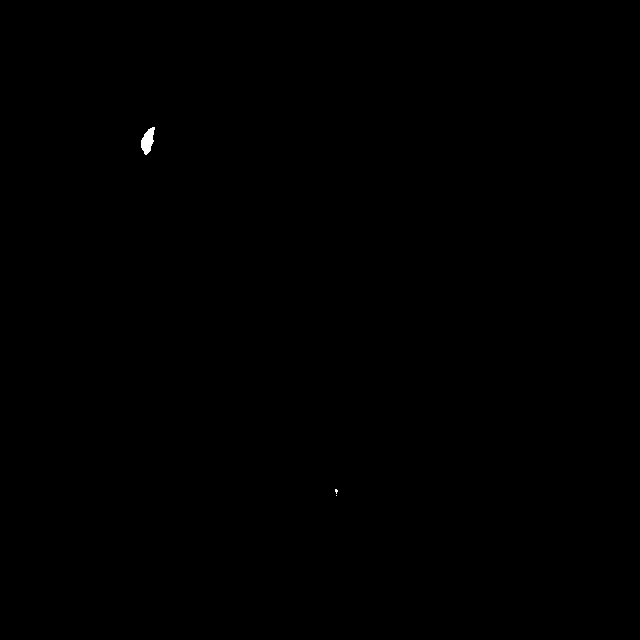

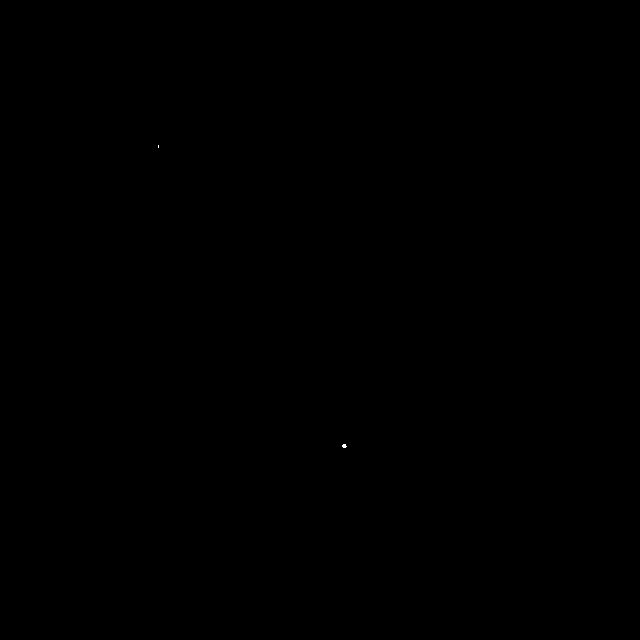

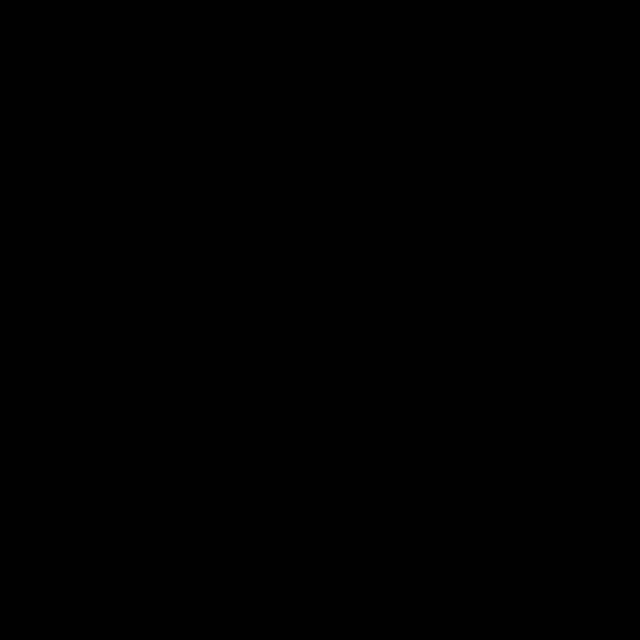

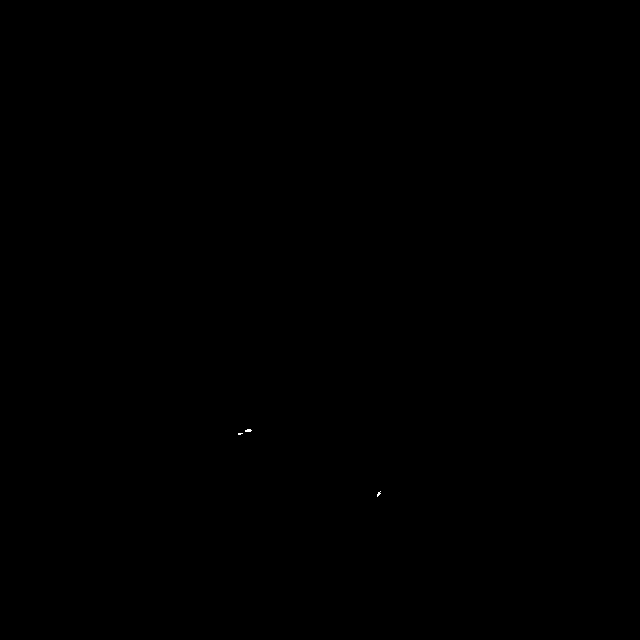

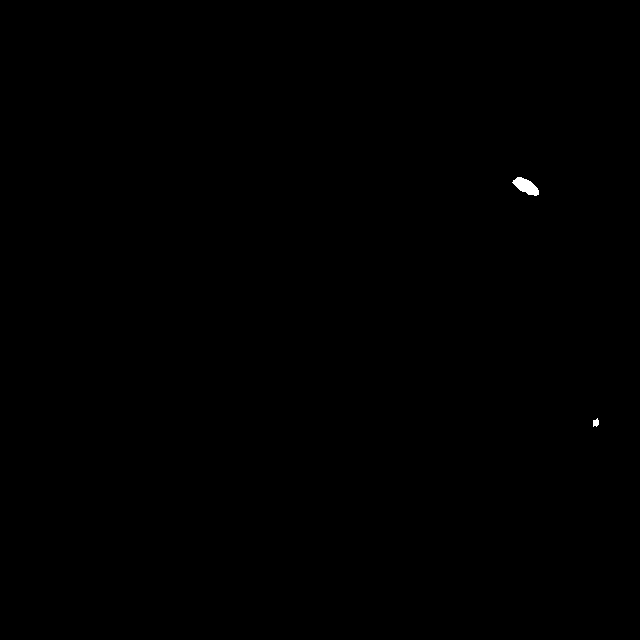

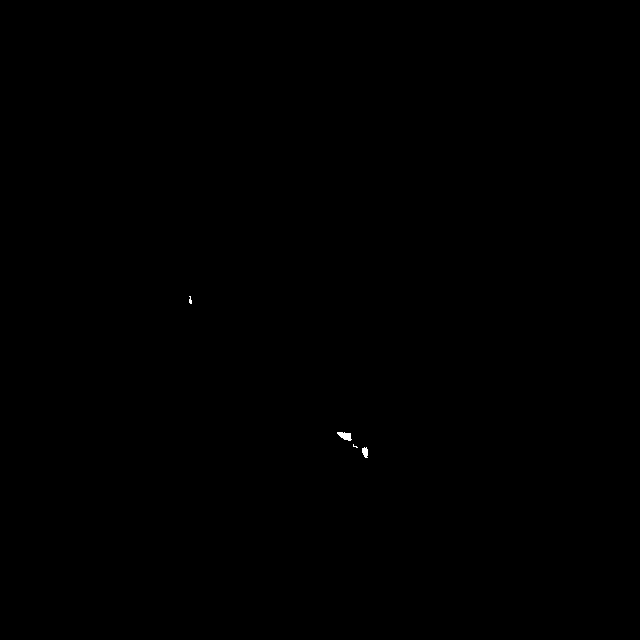

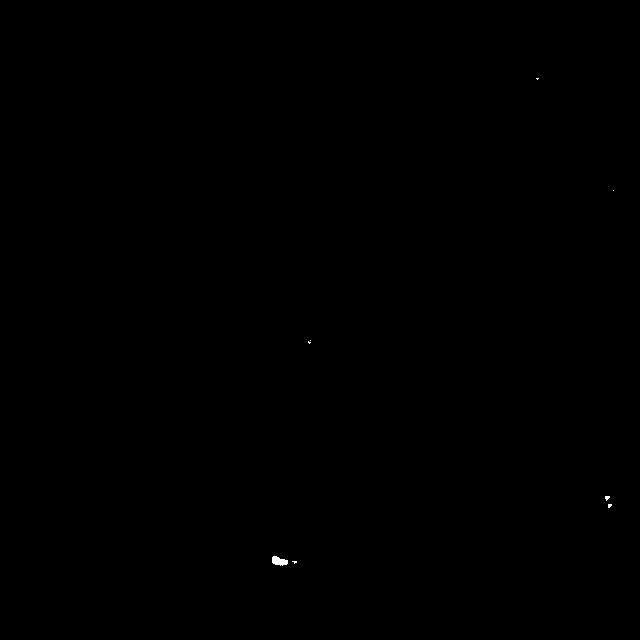

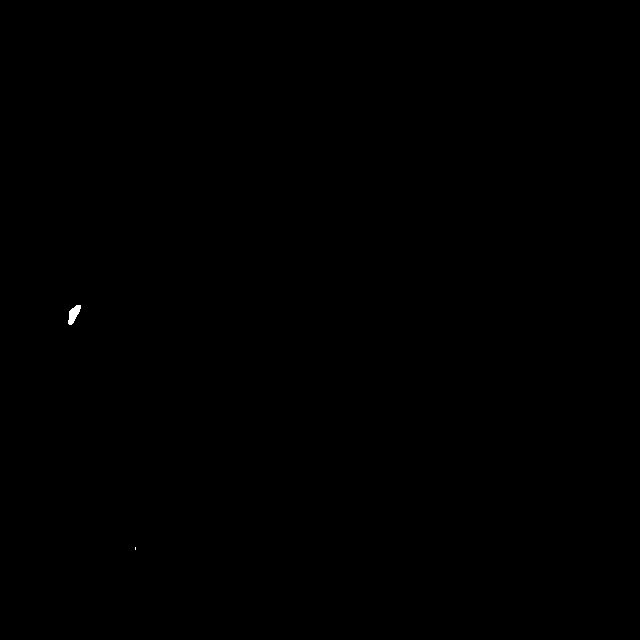

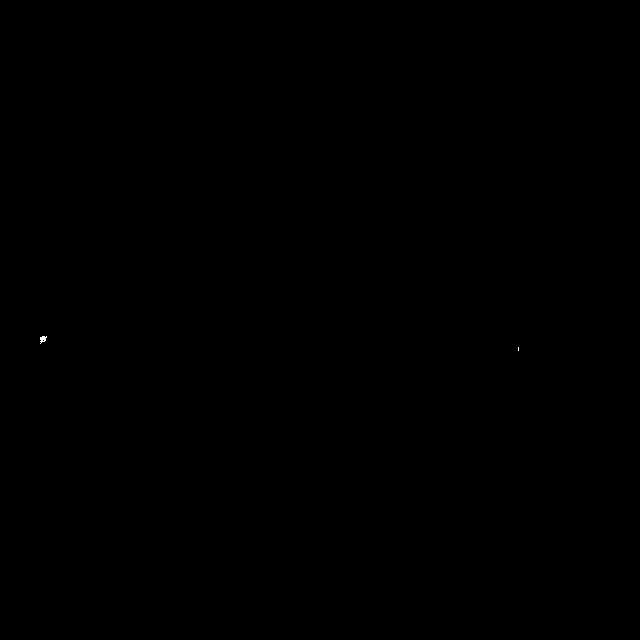

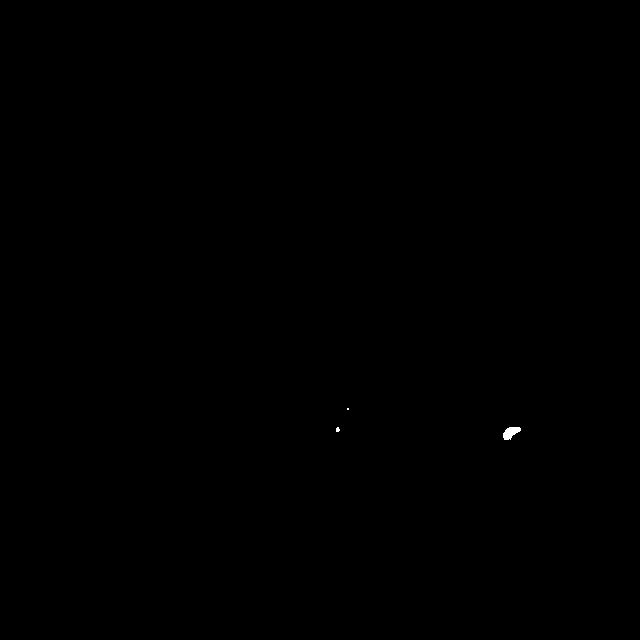

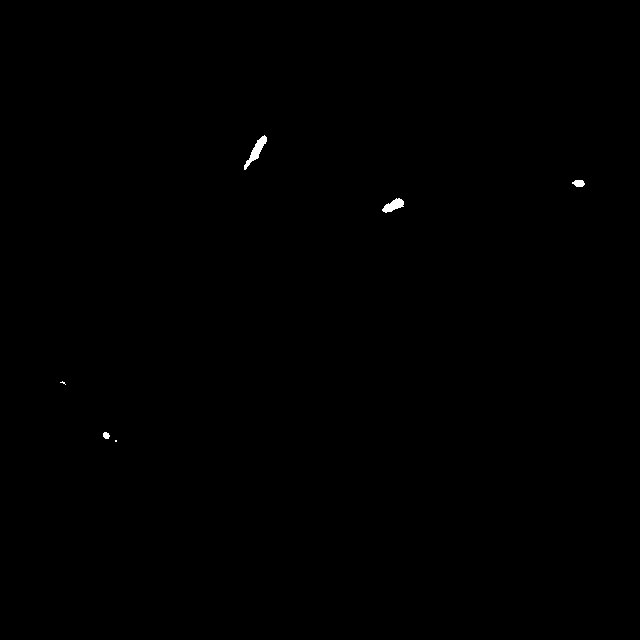

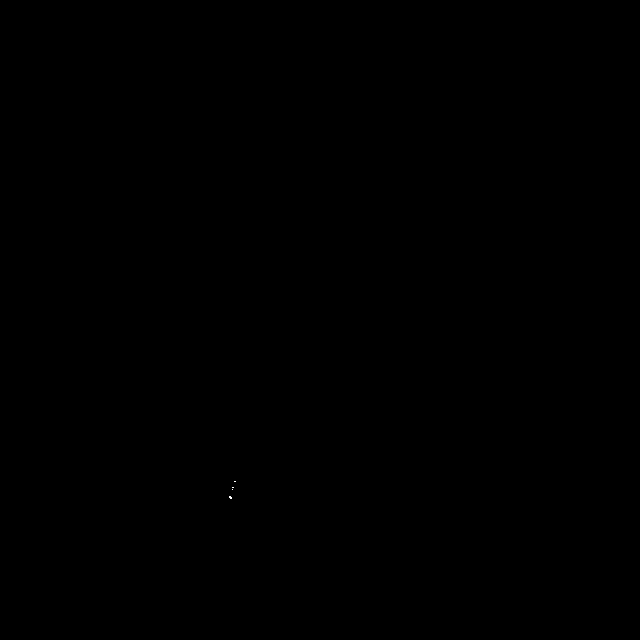

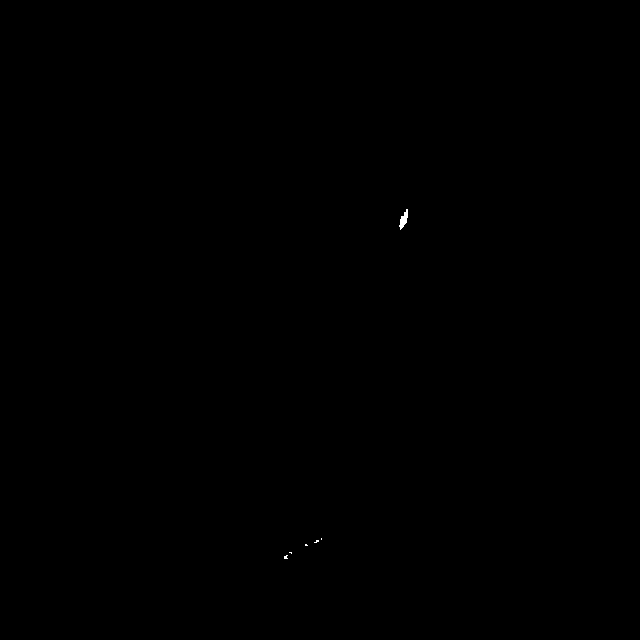

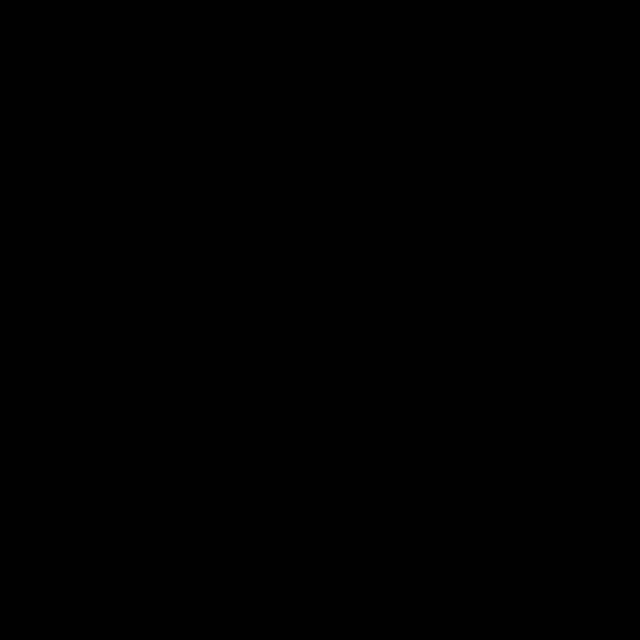

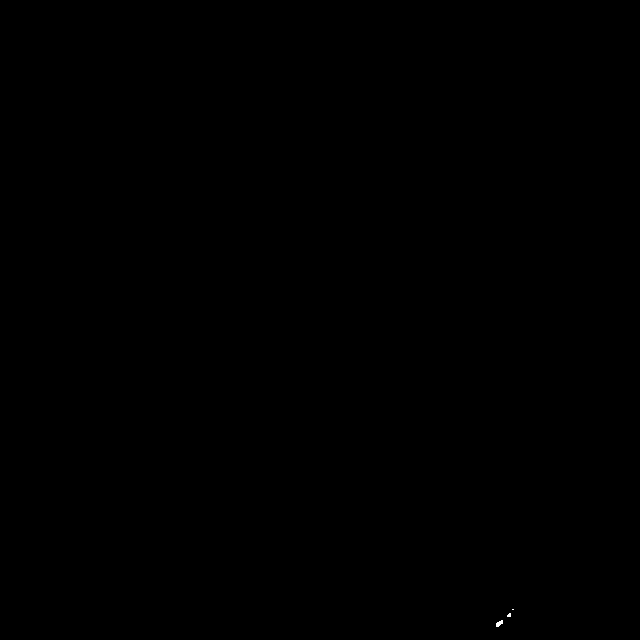

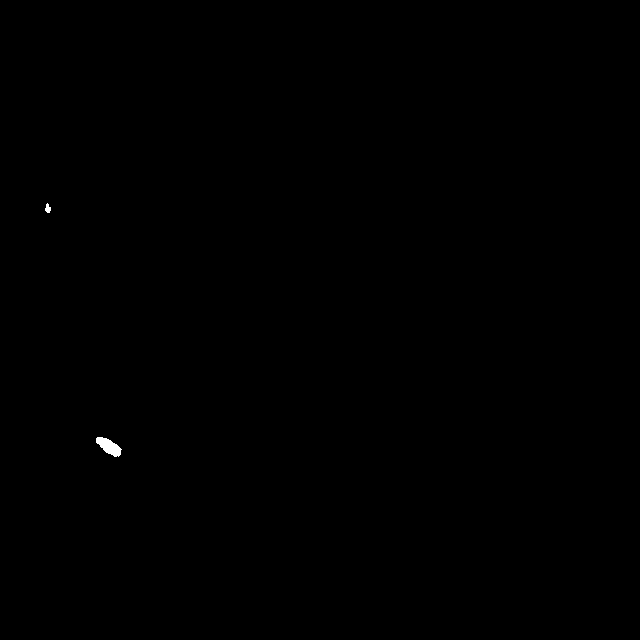

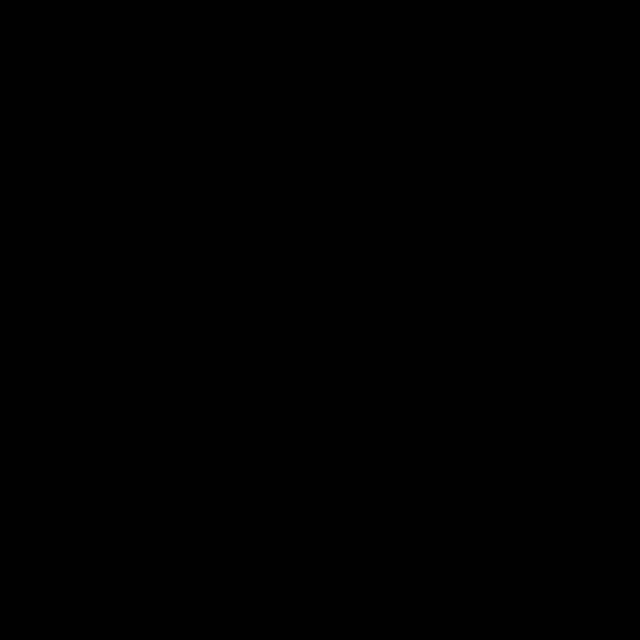

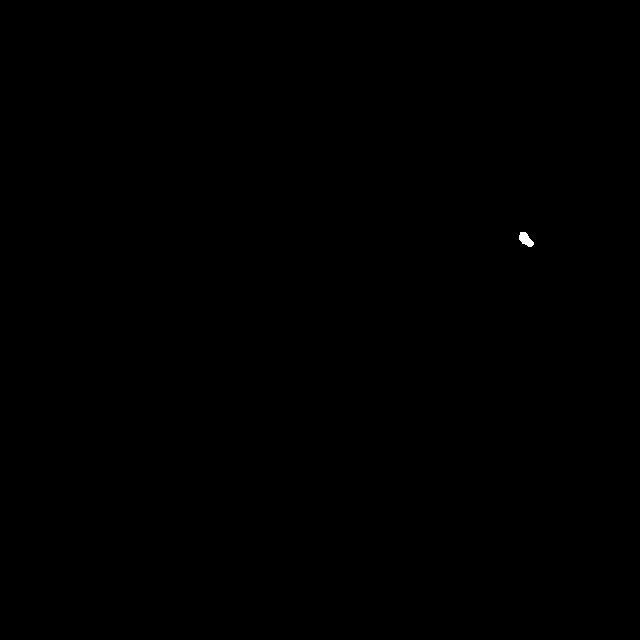

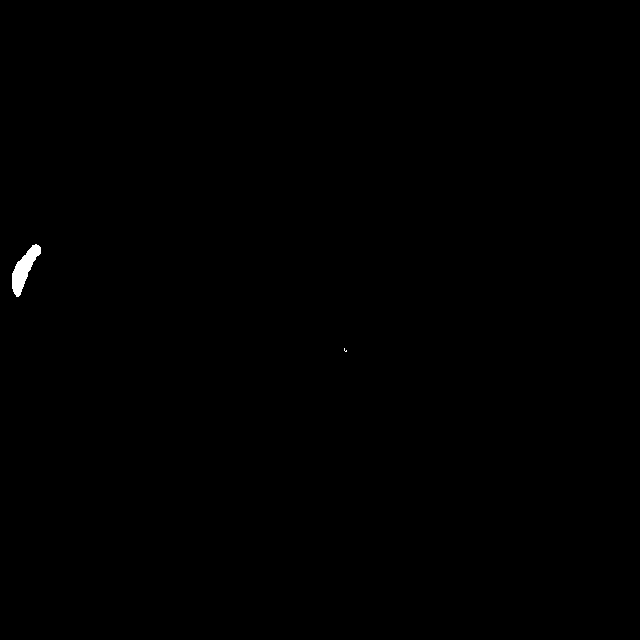

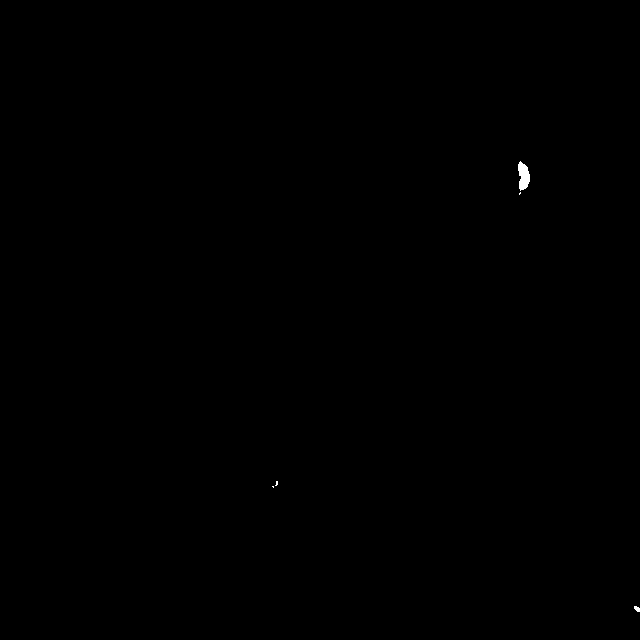

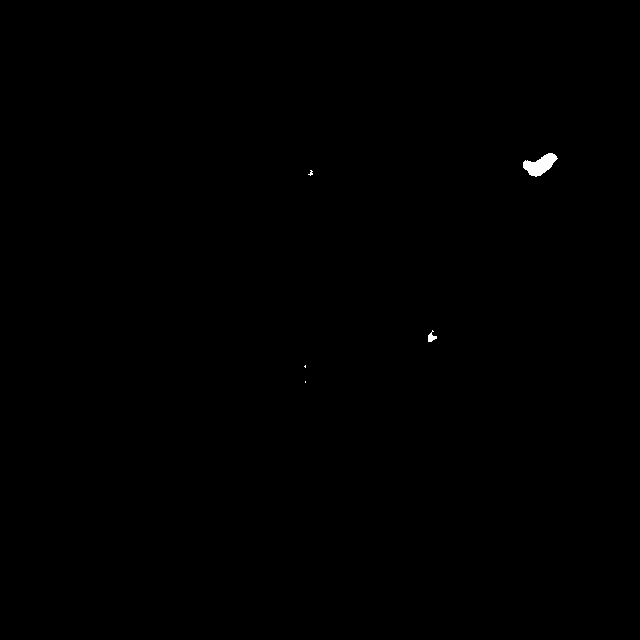

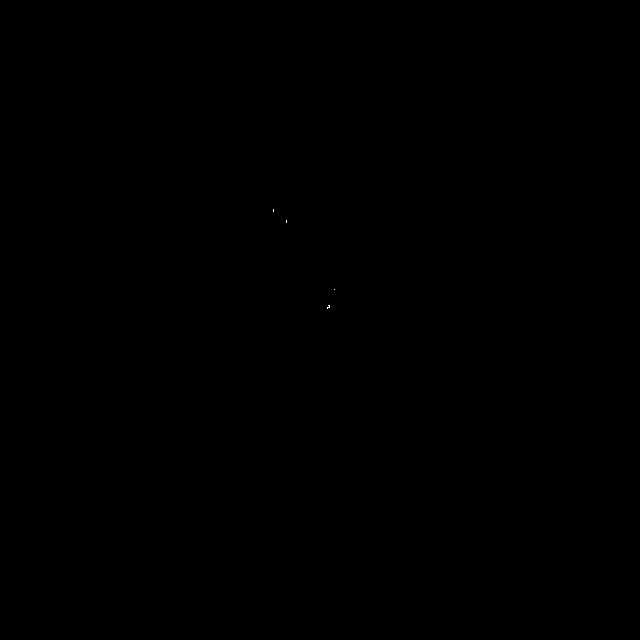

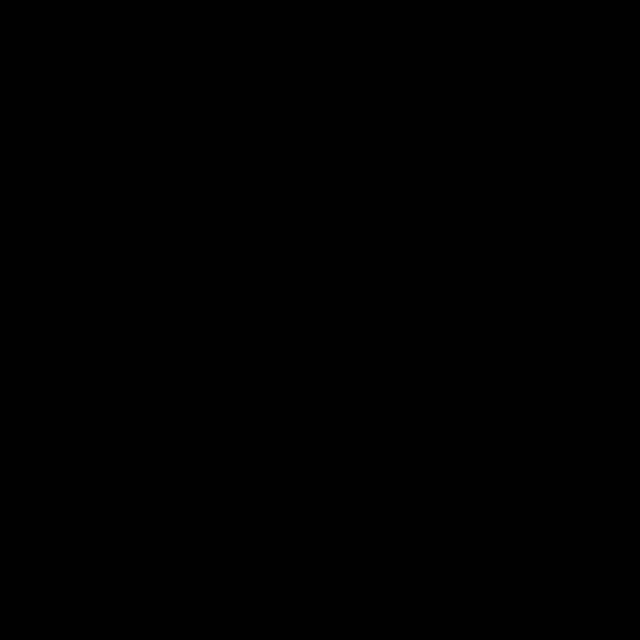

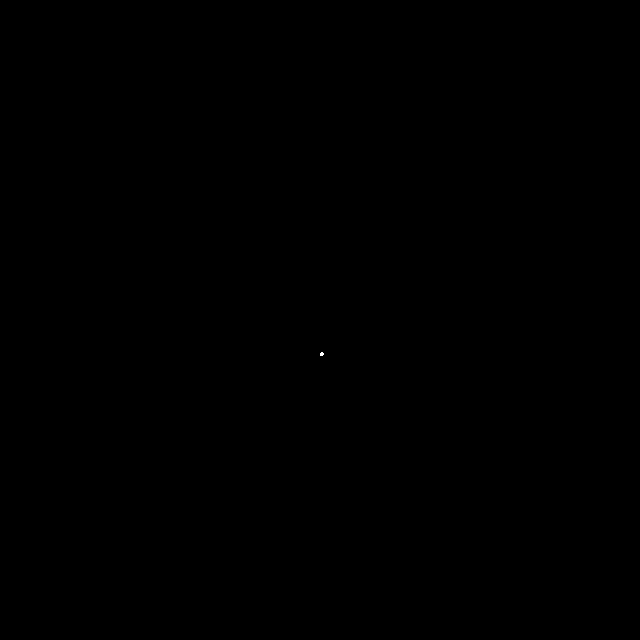

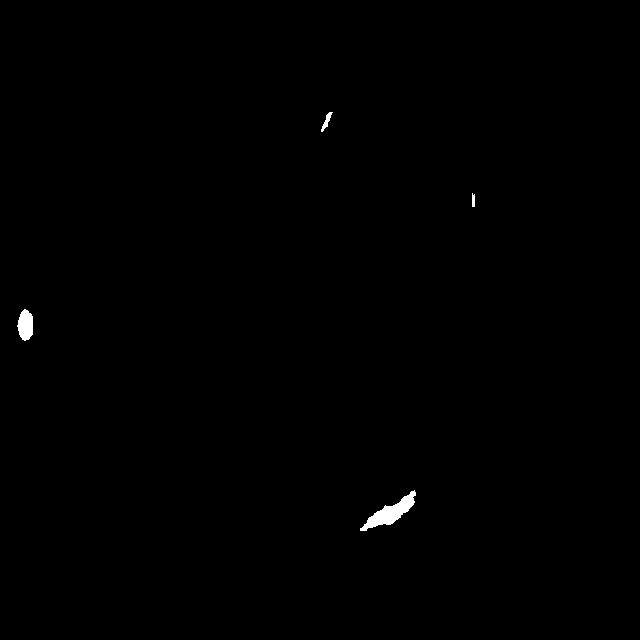

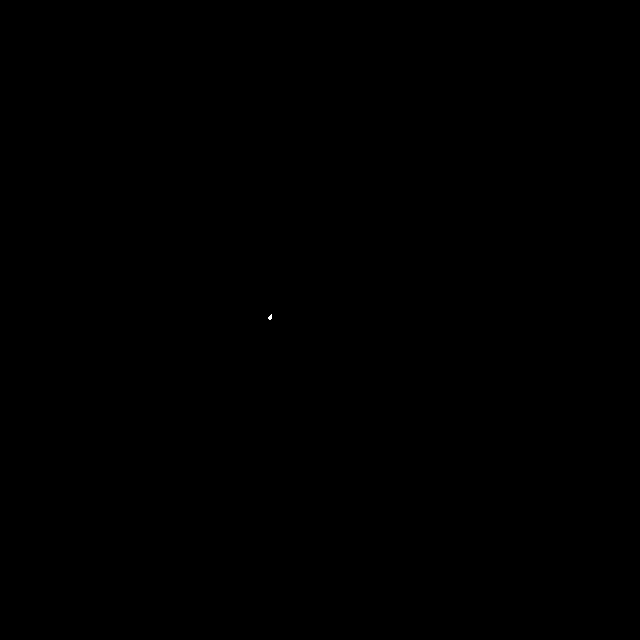

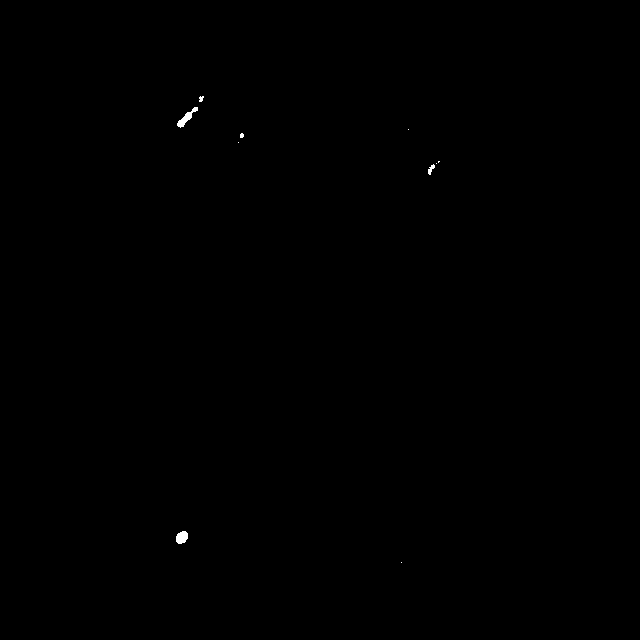

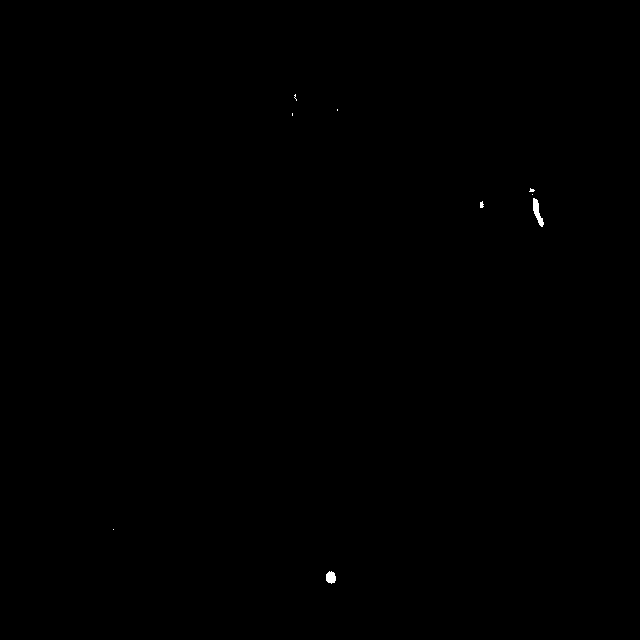

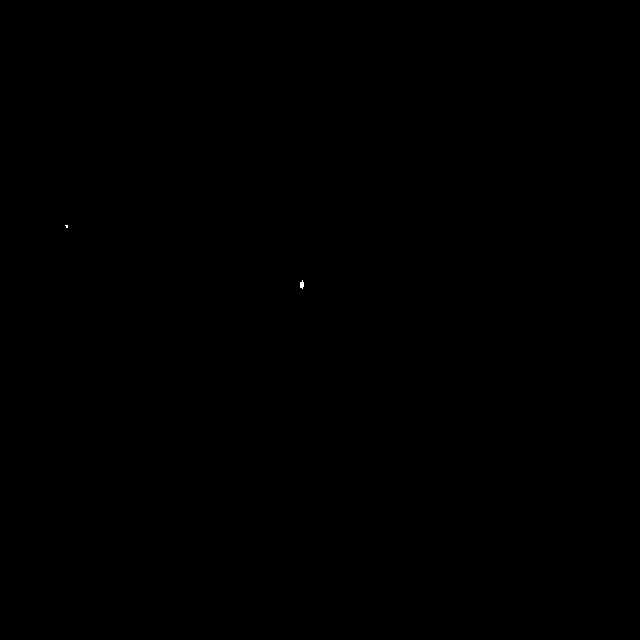

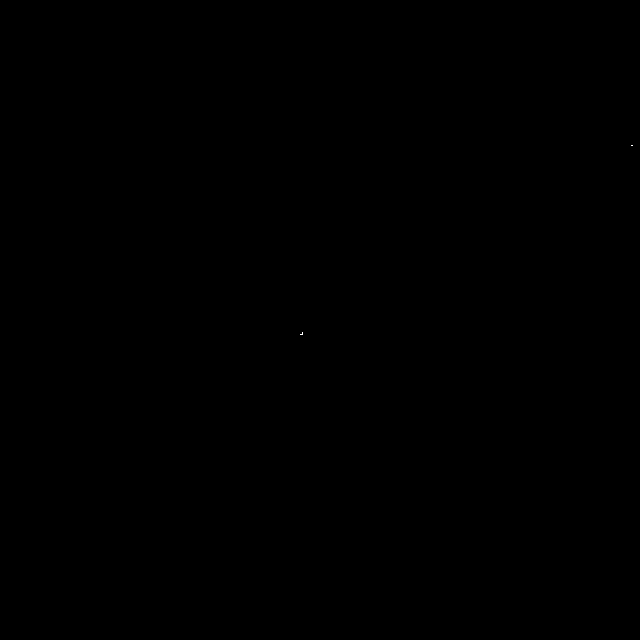

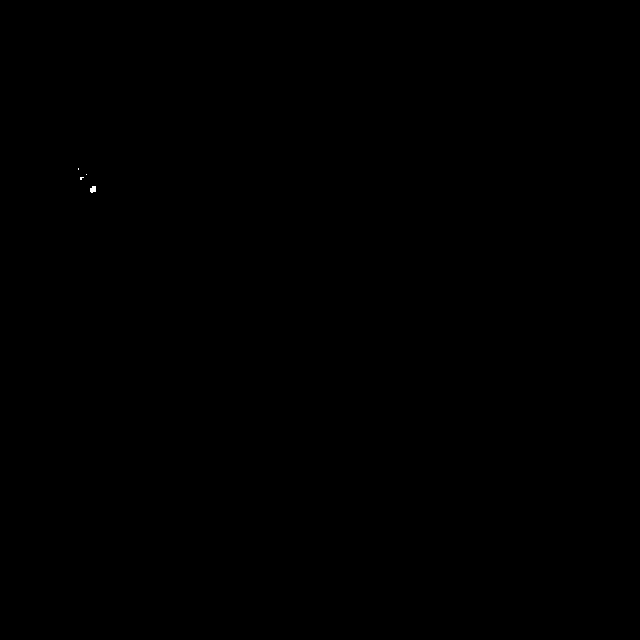

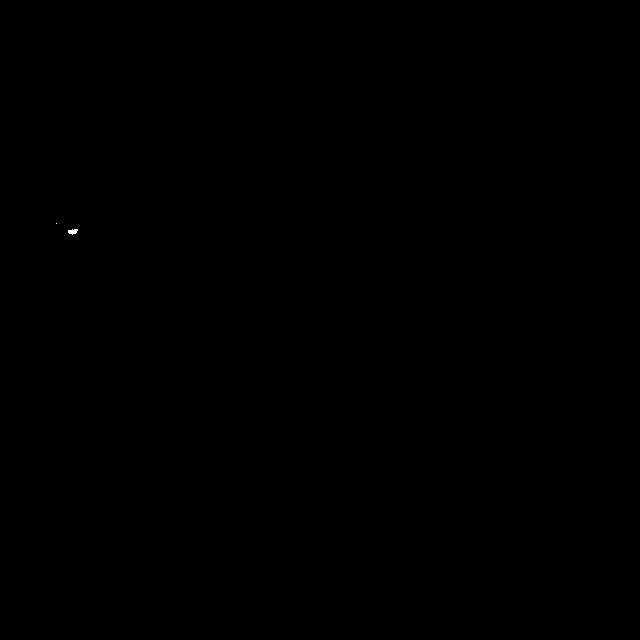

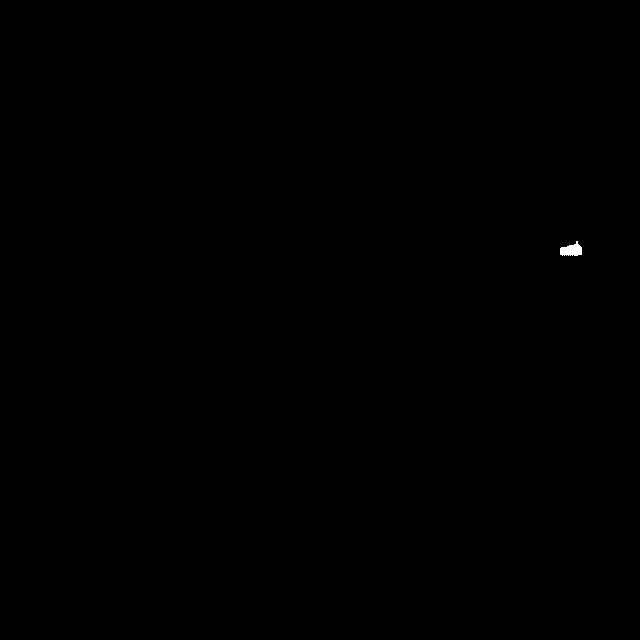

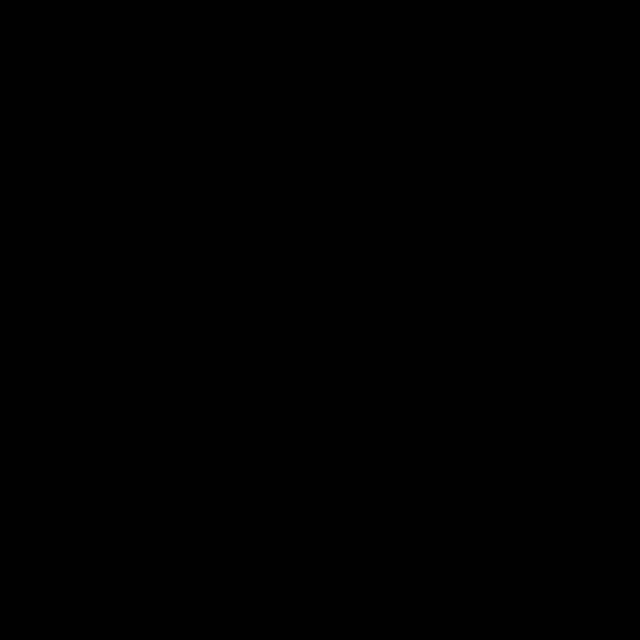

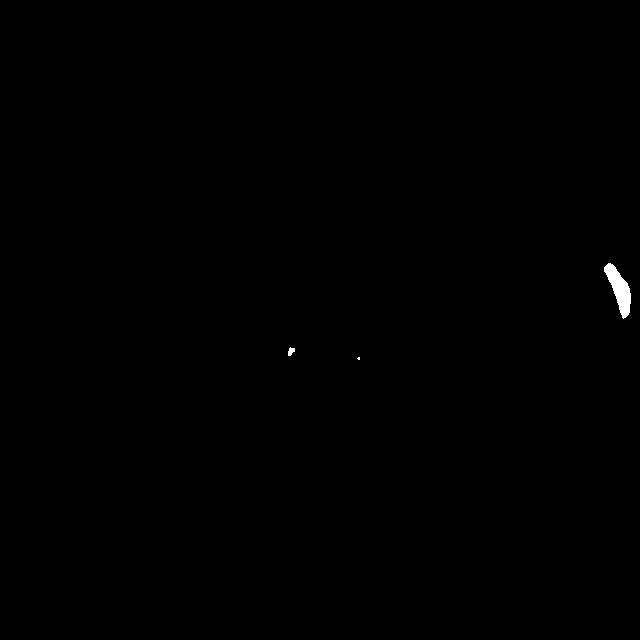

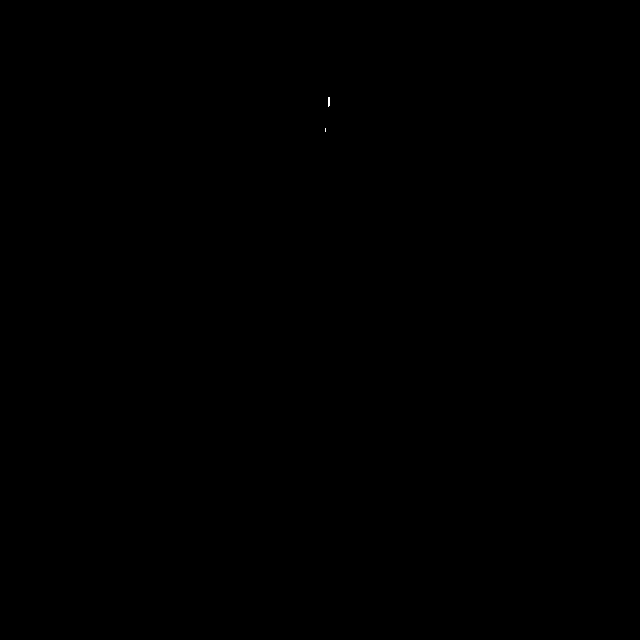

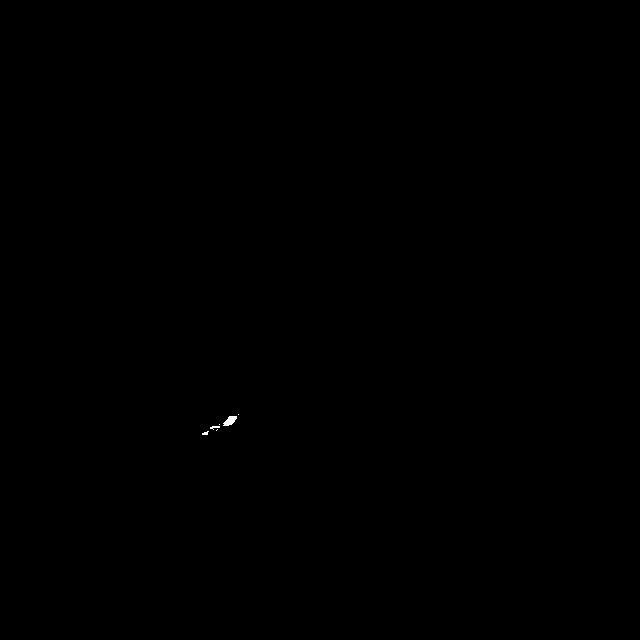

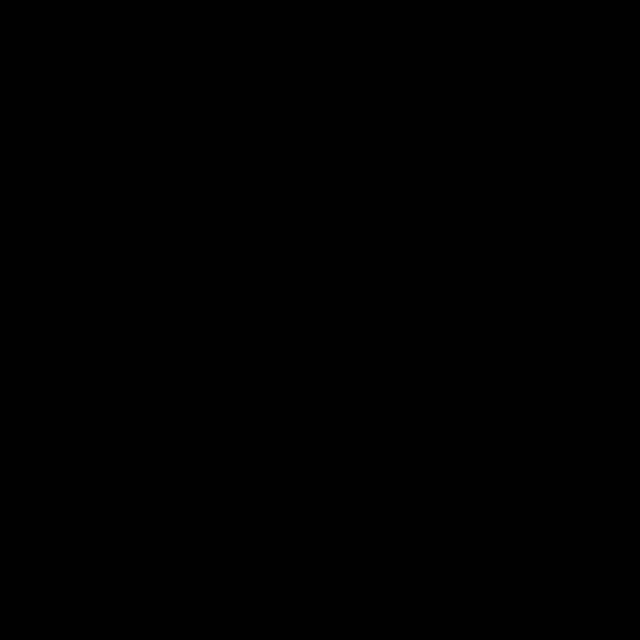

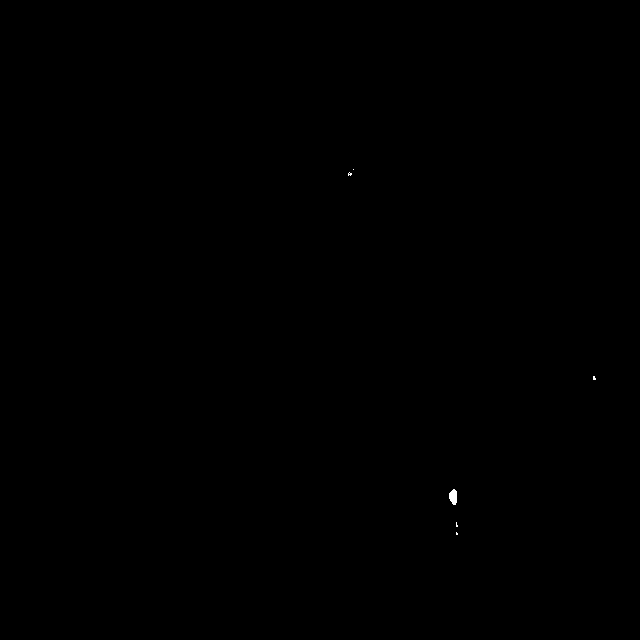

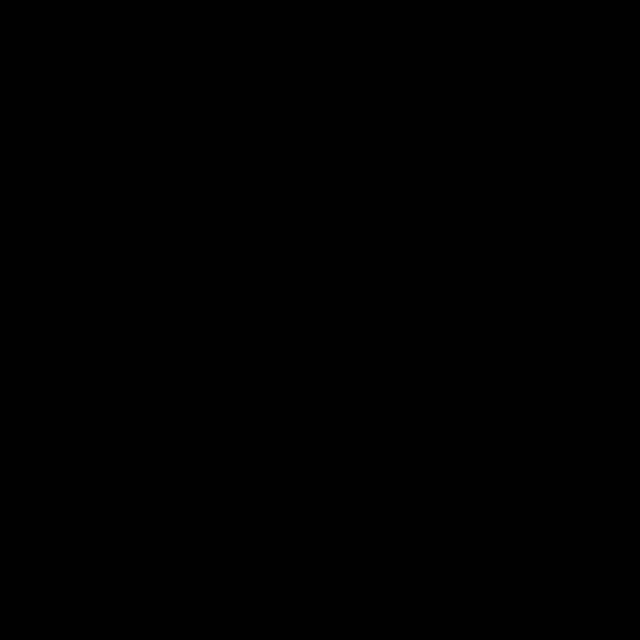

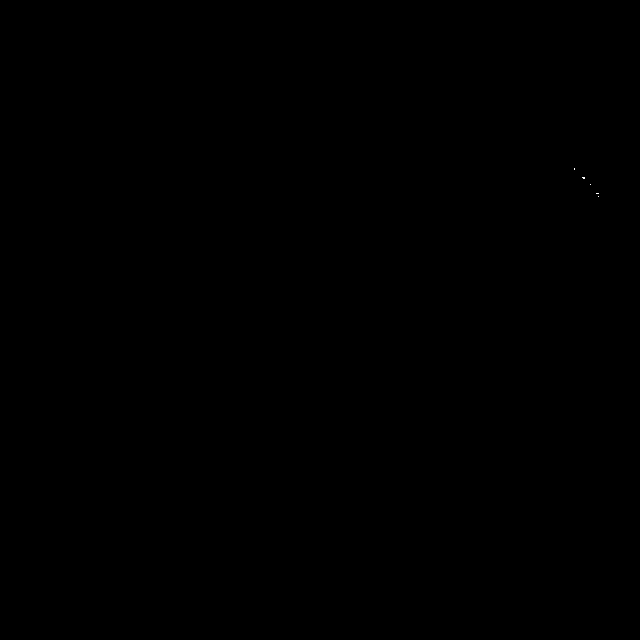

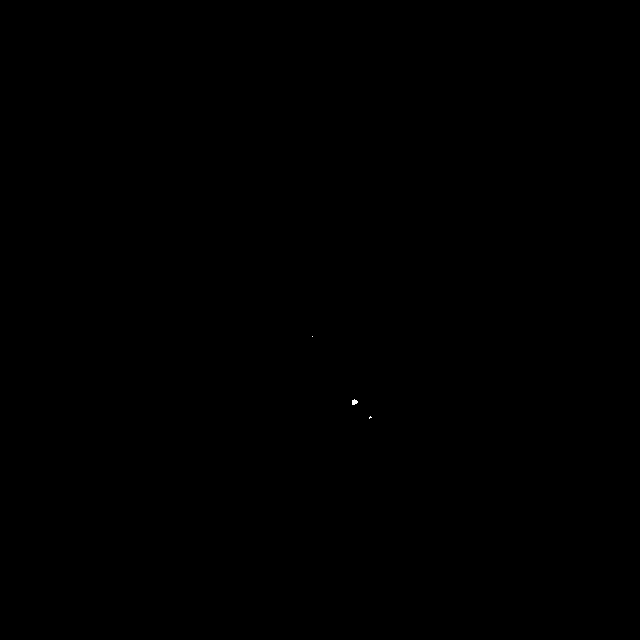

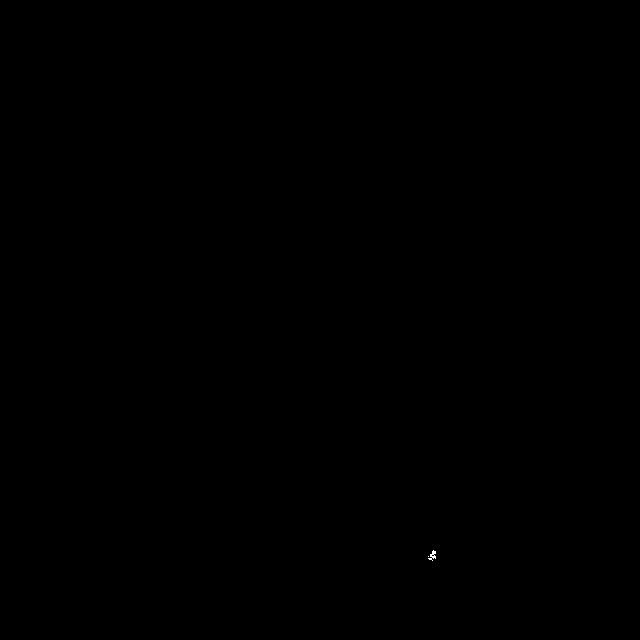

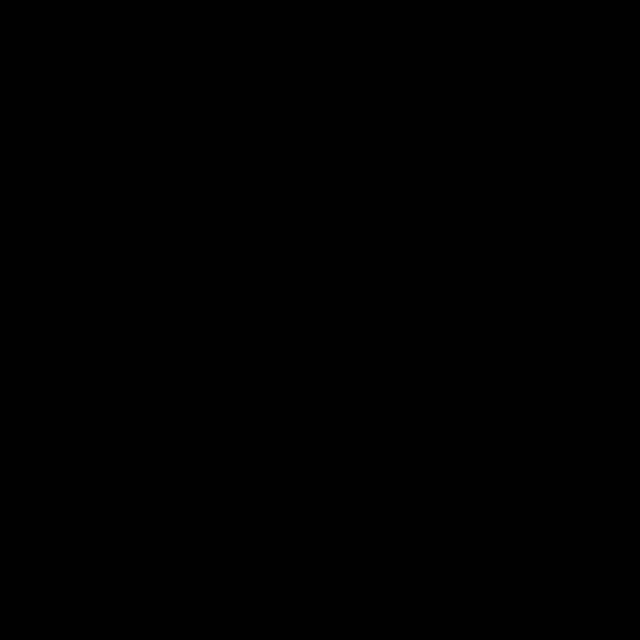

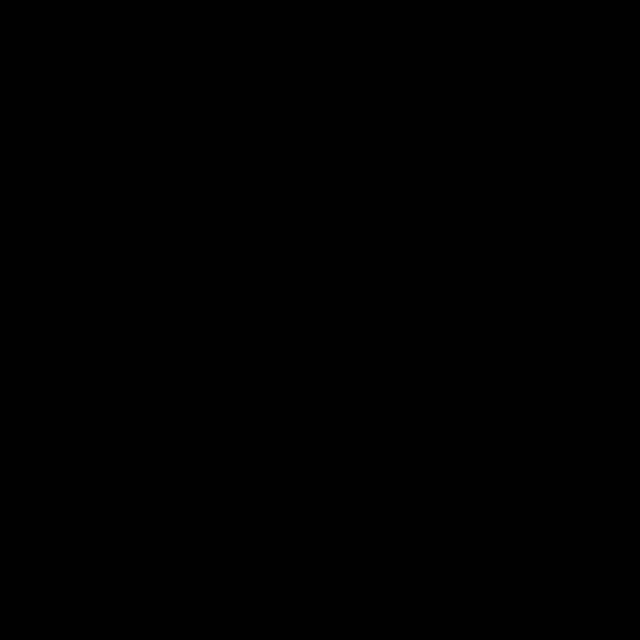

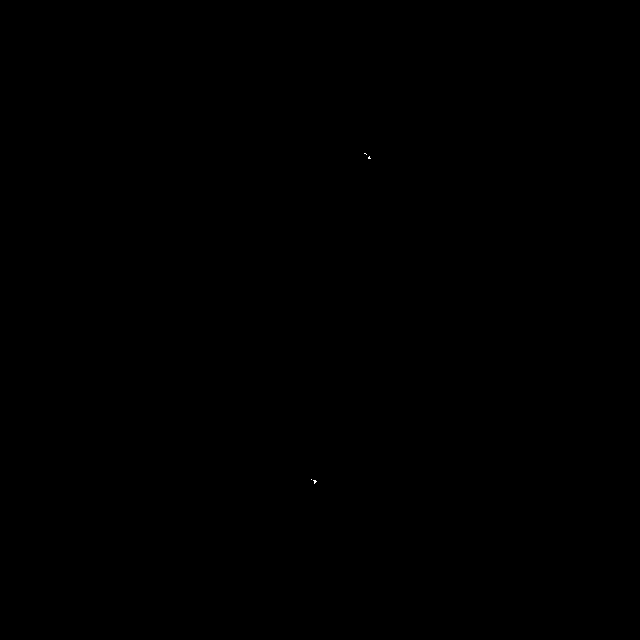

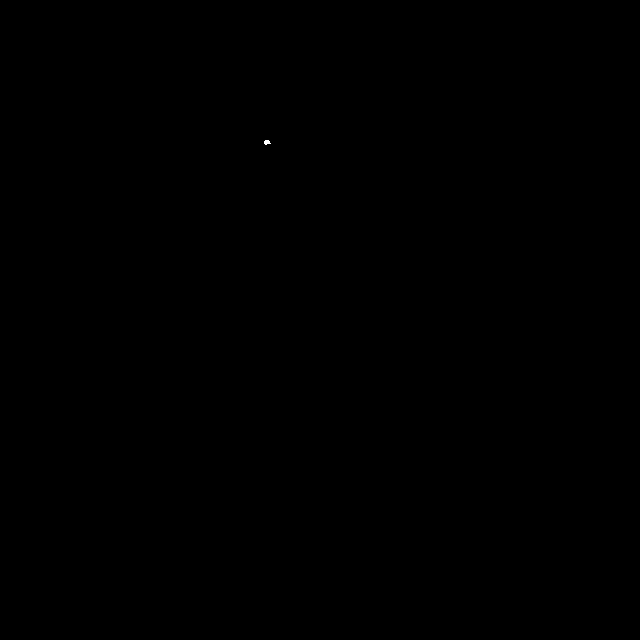

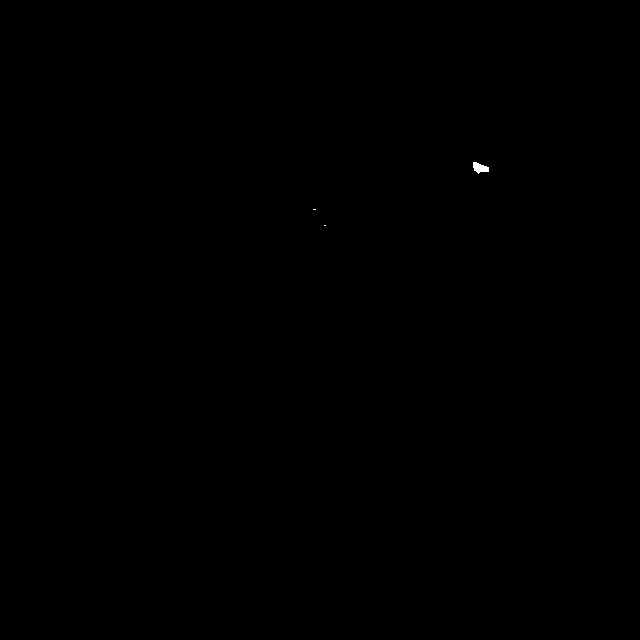

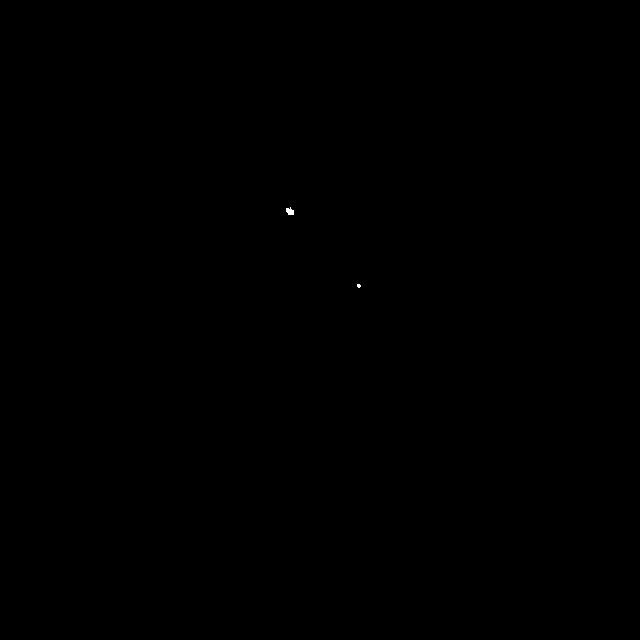

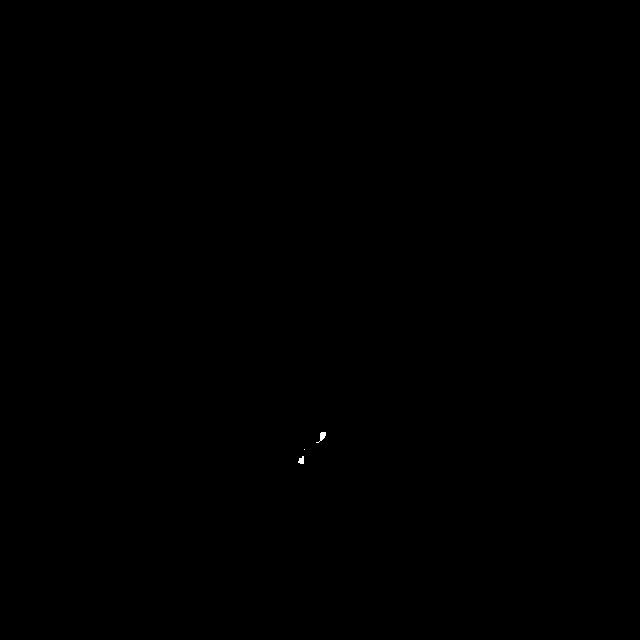

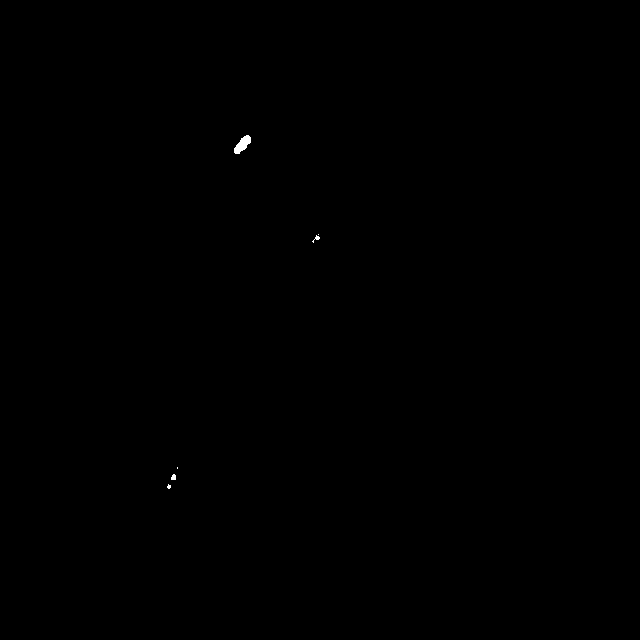

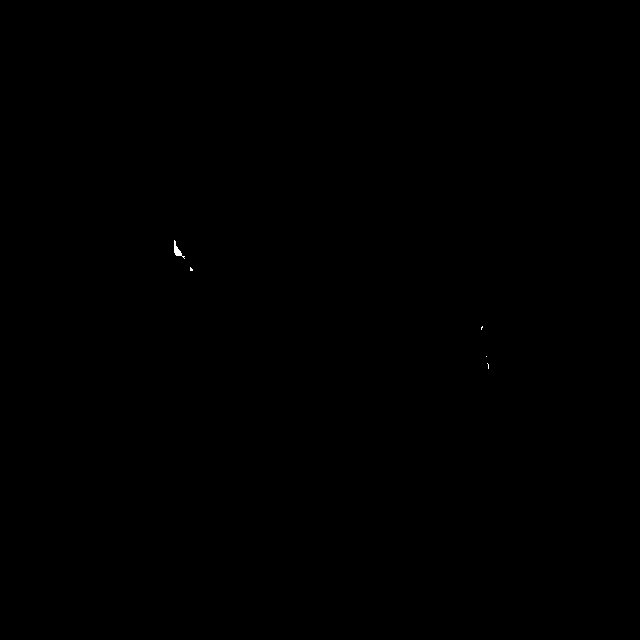

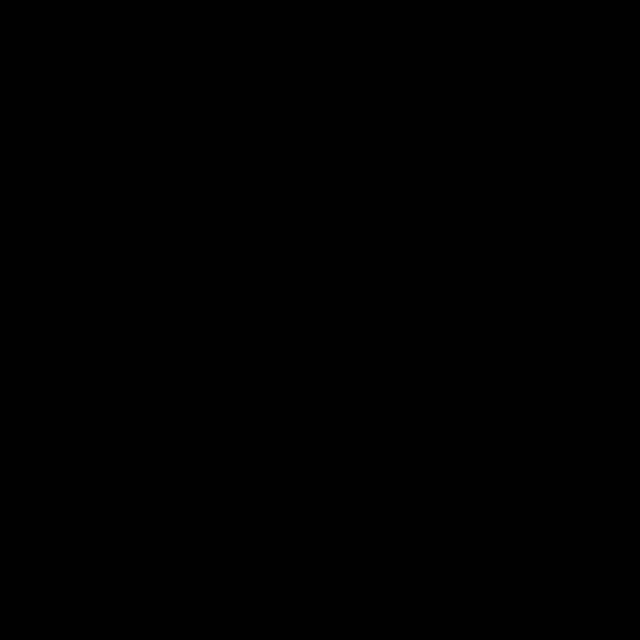

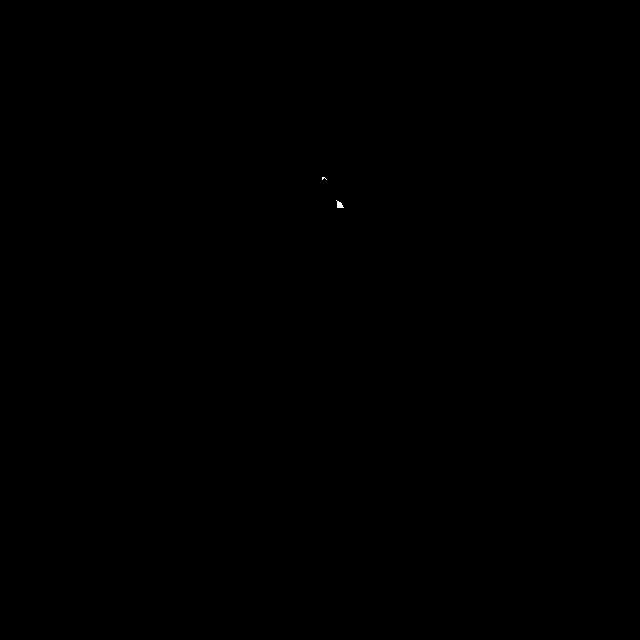

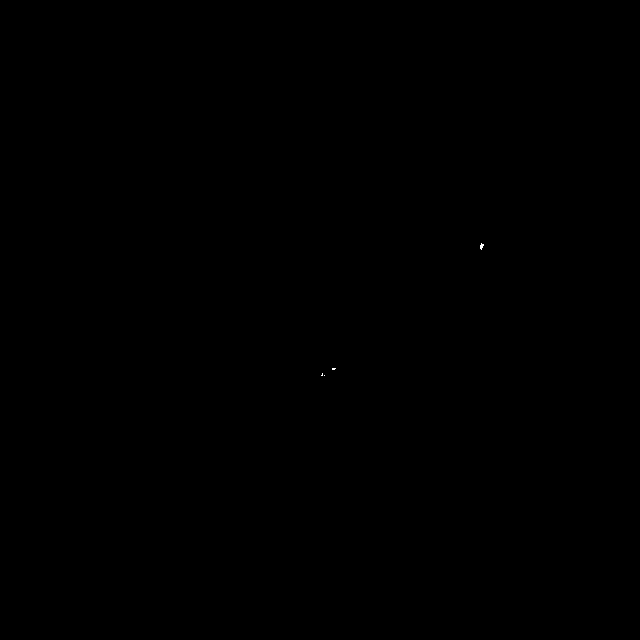

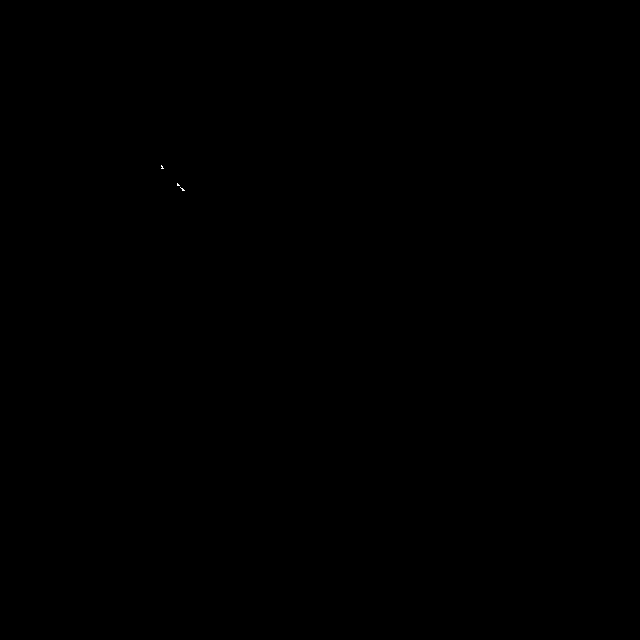

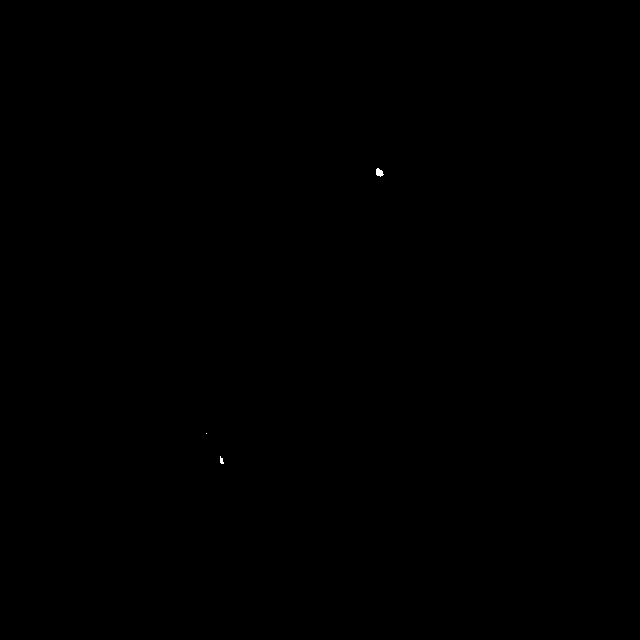

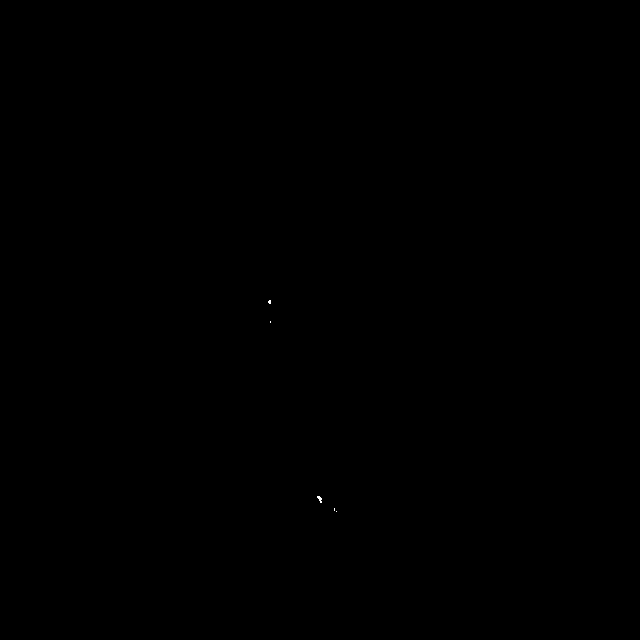

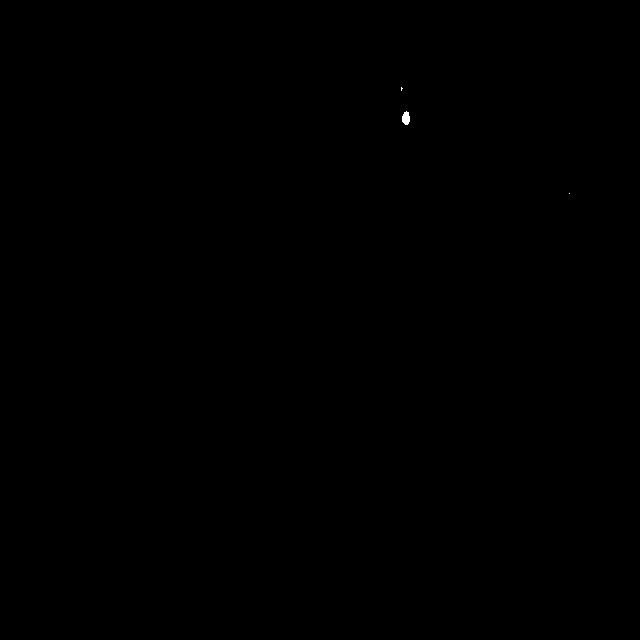

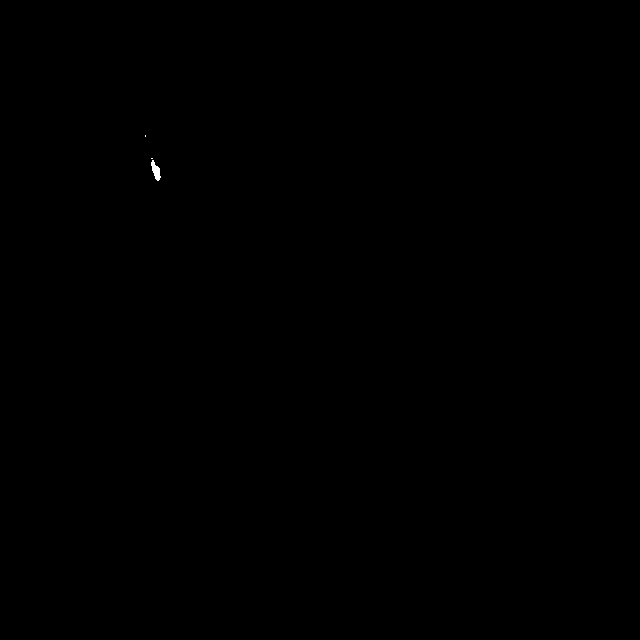

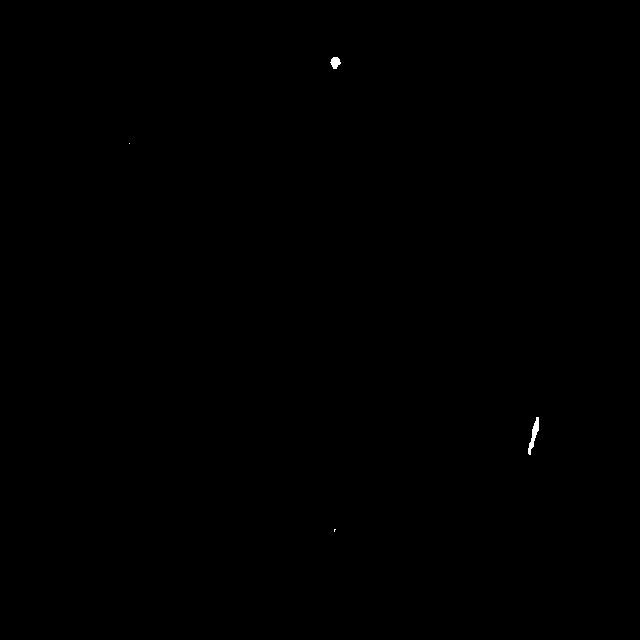

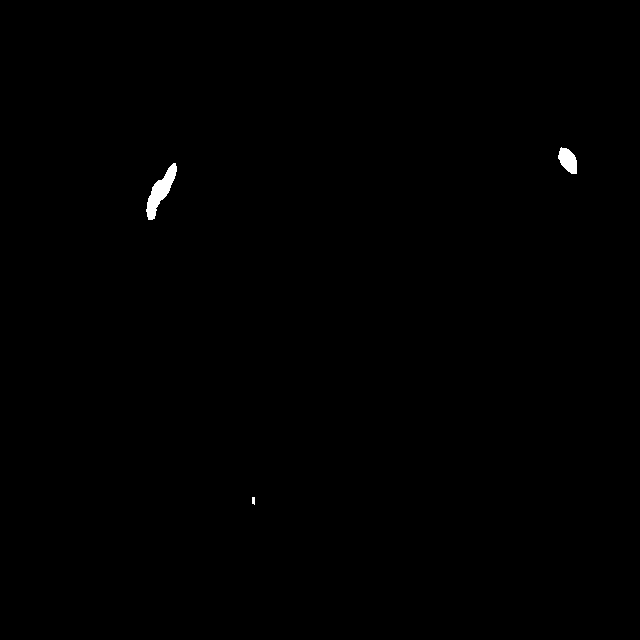

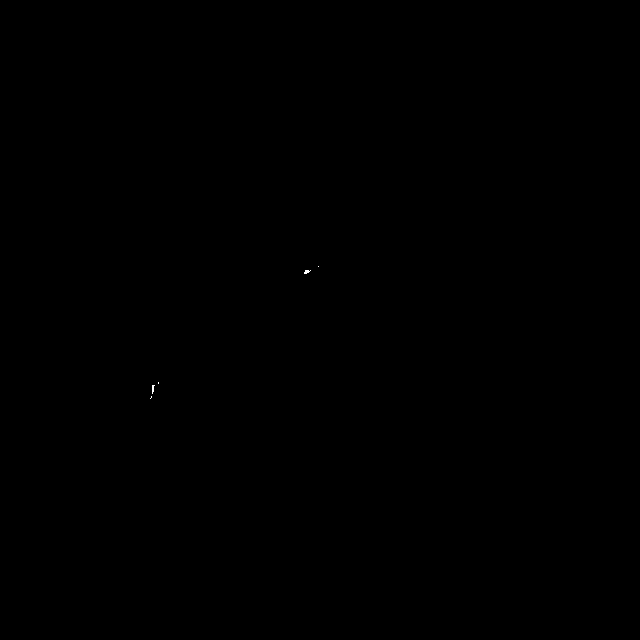

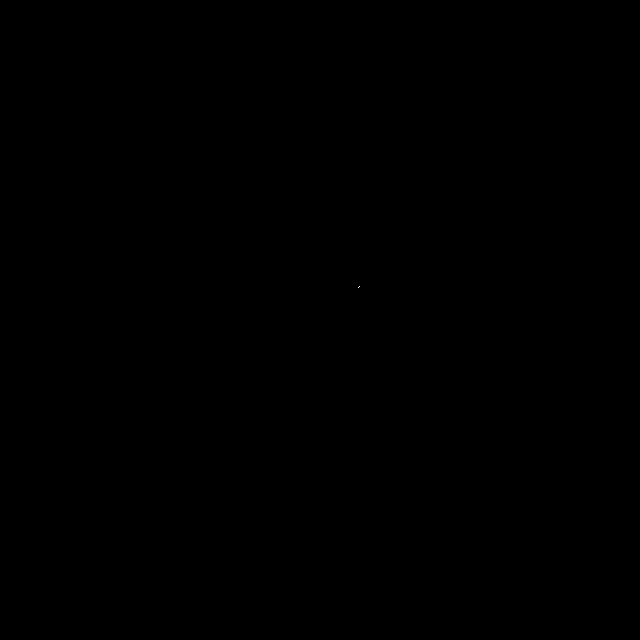

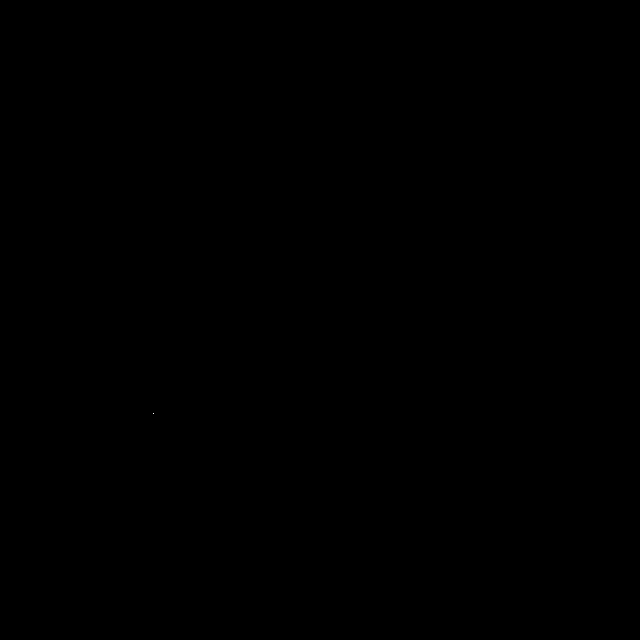

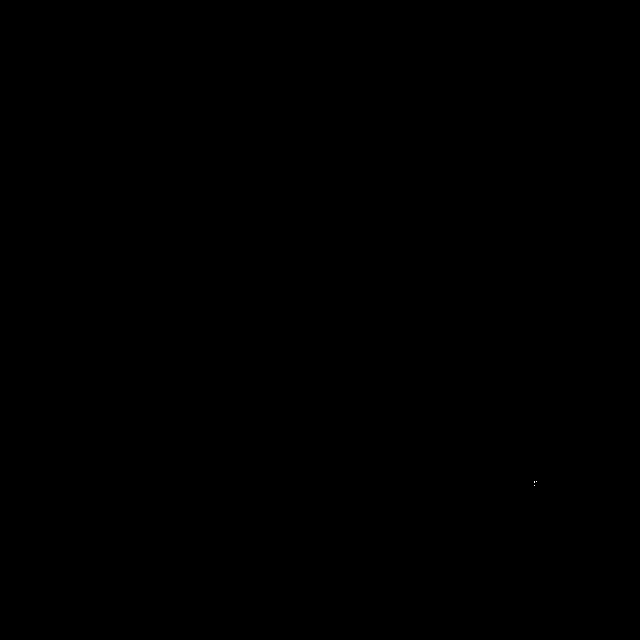

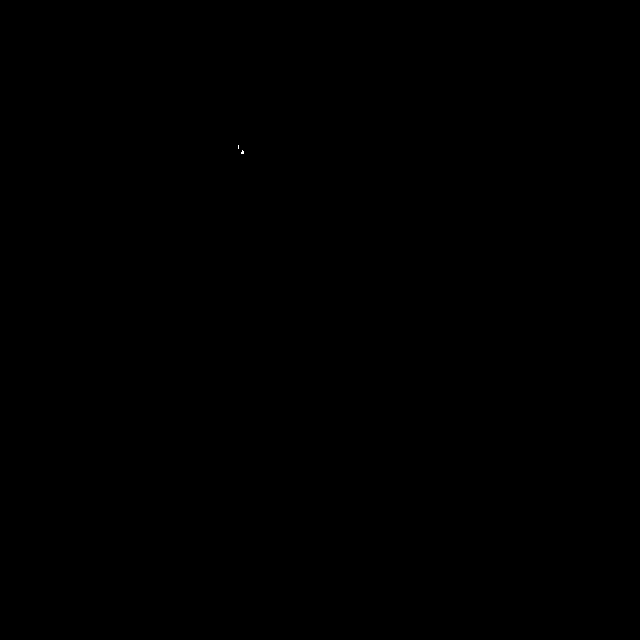

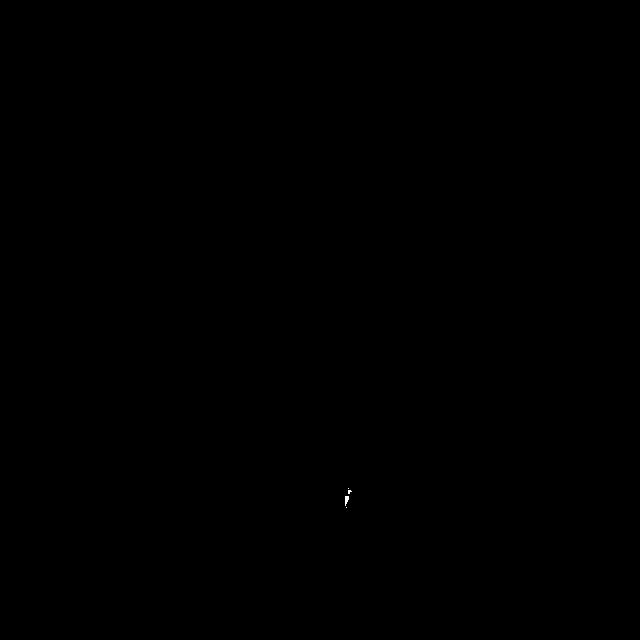

In [7]:
X = []
y = []
img_files = os.listdir(main_fold)
for img_file in img_files:
  # print(cv2.imread(img_file))
  img_file_path = os.path.join(main_fold, img_file)
  orig_img = cv2.imread(img_file_path)
  #cv2_imshow(orig_img)
  img = orig_img.copy()
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, img_th = cv2.threshold(img_gray,30,255,cv2.THRESH_BINARY_INV)
  img_th_inv = 255-img_th
  # a = image.img_to_array(orig_img)

  # # Performing image segmentation on input image
  img_seg = image_segmentation(orig_img)
  cv2_imshow(img_seg)
  # # Bitwise AND between segmented image and grayscale thresholded image to remove any bounding markers
  img_seg = cv2.bitwise_and(img_seg,img_th_inv)

  # # Resizing the segmented image to standard size of 600x800 for further processing
  img_seg = cv2.resize(img_seg,(img_shape[1],img_shape[0]))


  # # Post processing on the segmented image
  img_mask = image_postprocess(img_seg)

  #    # Save the mask image (optional)
  # mask_path = os.path.join(output_dir, os.path.basename(img_file_path))
  # cv2.imwrite(mask_path, img_mask)

  # # Add the input image and mask image pair to the dataset
  X.append(img)
  y.append(img_mask)



  # break

In [8]:
X_train = np.array(X)
y_train= np.array(y)

In [9]:
print(y_train.shape)

(100, 640, 640)


# **Validation data**


In [10]:
main_fold1 = "/content/drive/MyDrive/tuberculosis_new_final/valid"
# main_fold = "/content/drive/MyDrive/tuberculosis_microscpic_images/Overlapping_Microscope-3_set6"
output_dir1 = "/content/drive/MyDrive/tuberculosis_new_final/mask/valid"

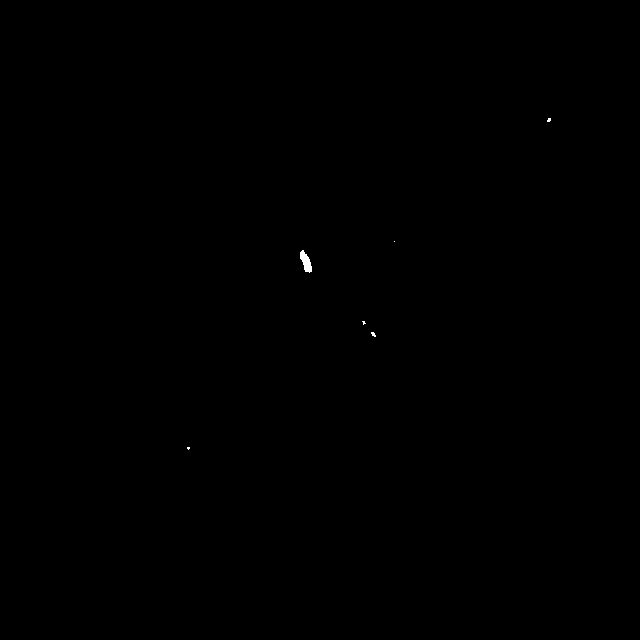

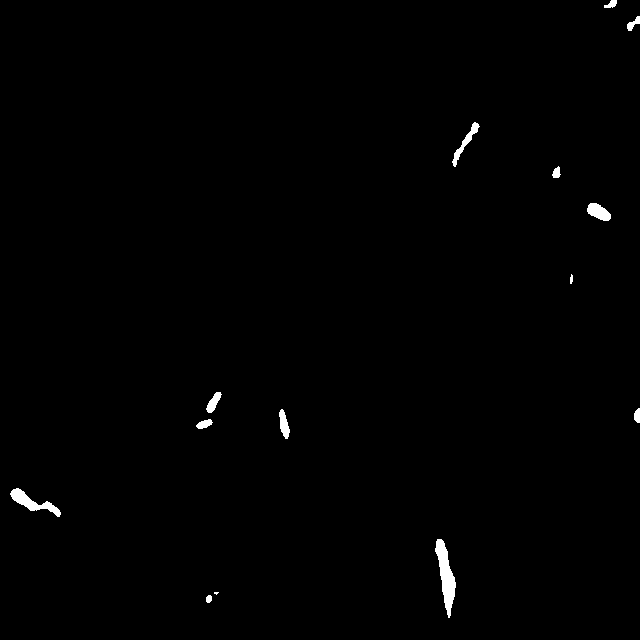

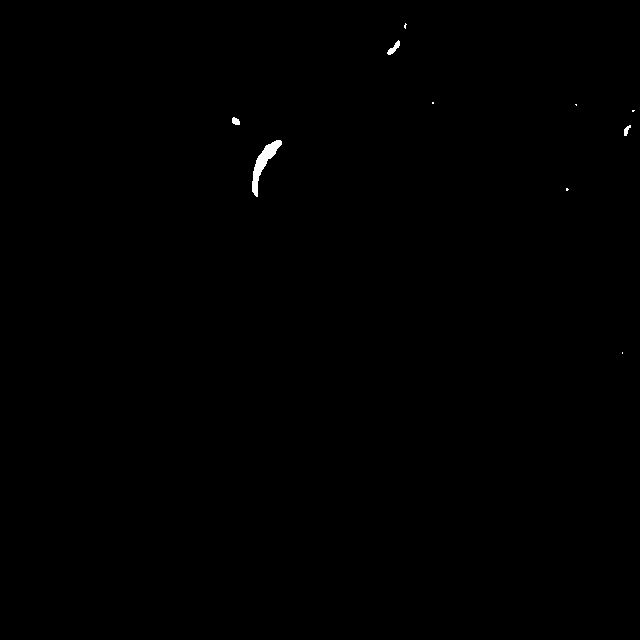

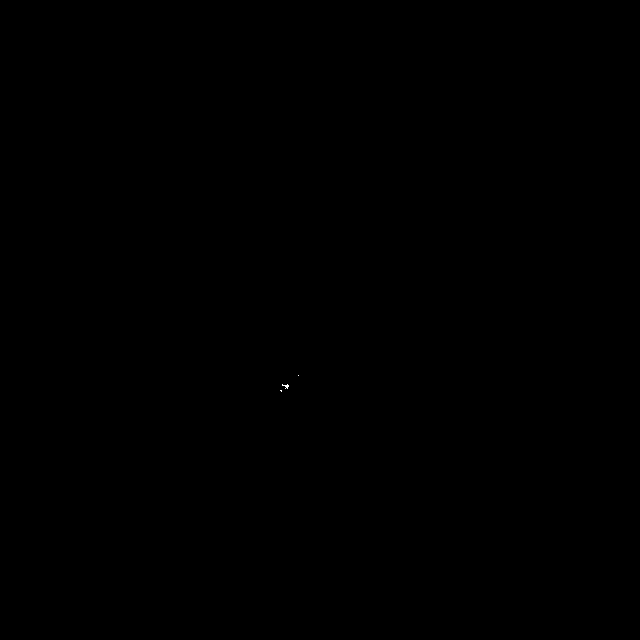

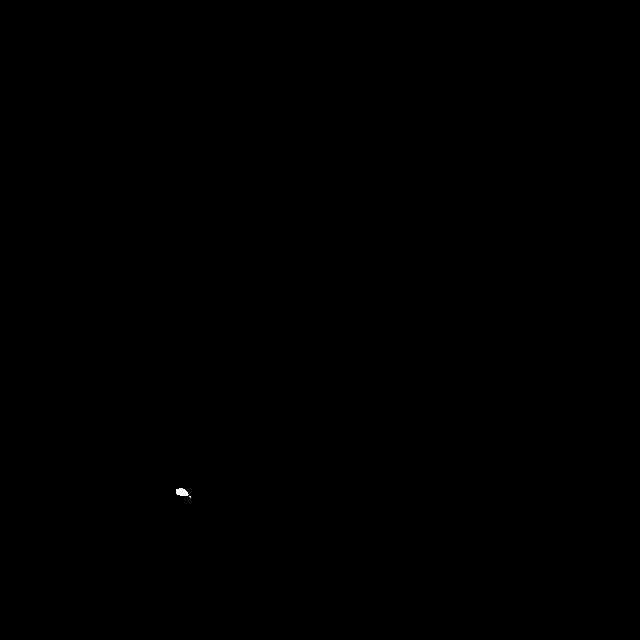

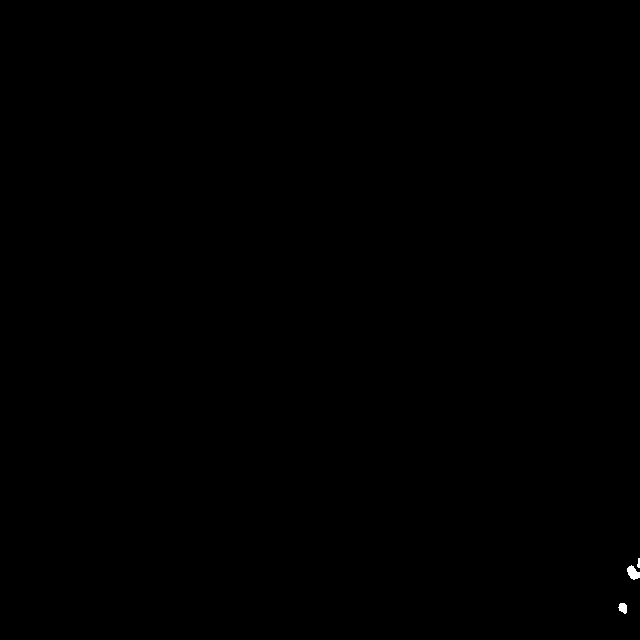

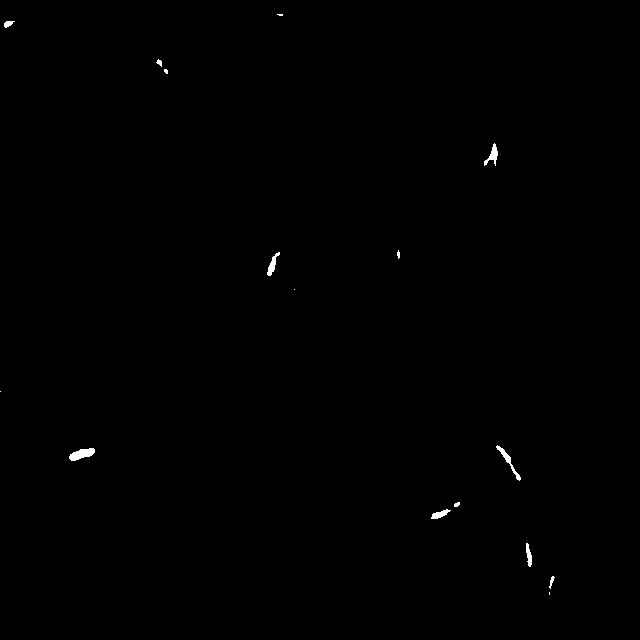

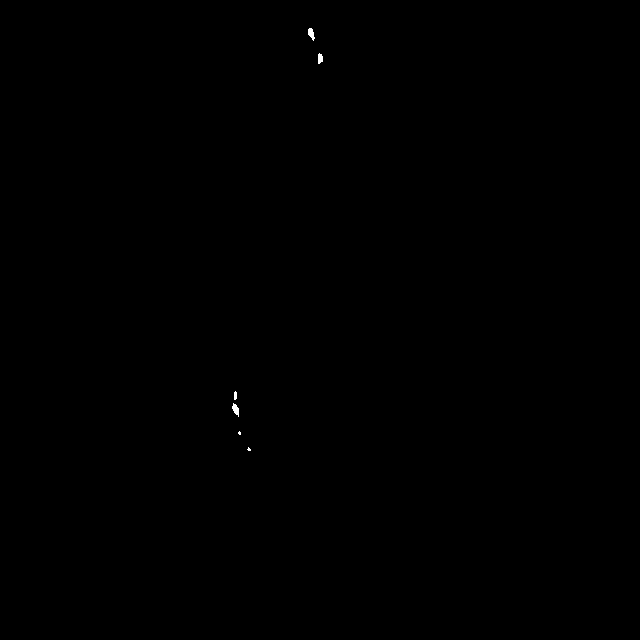

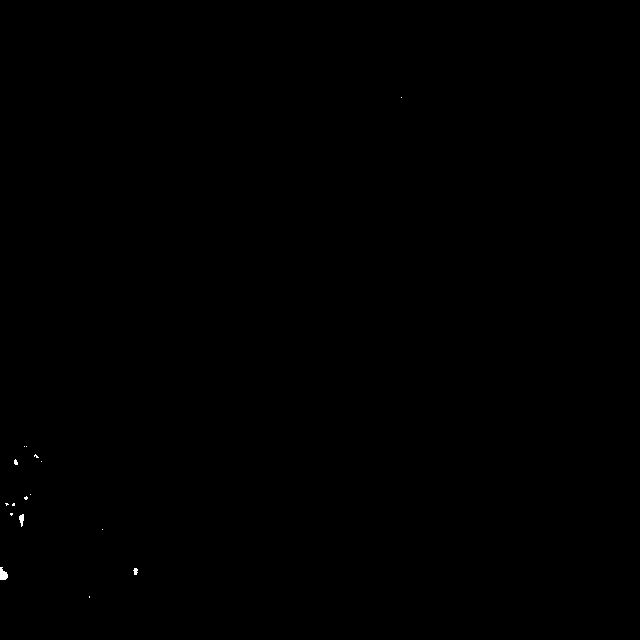

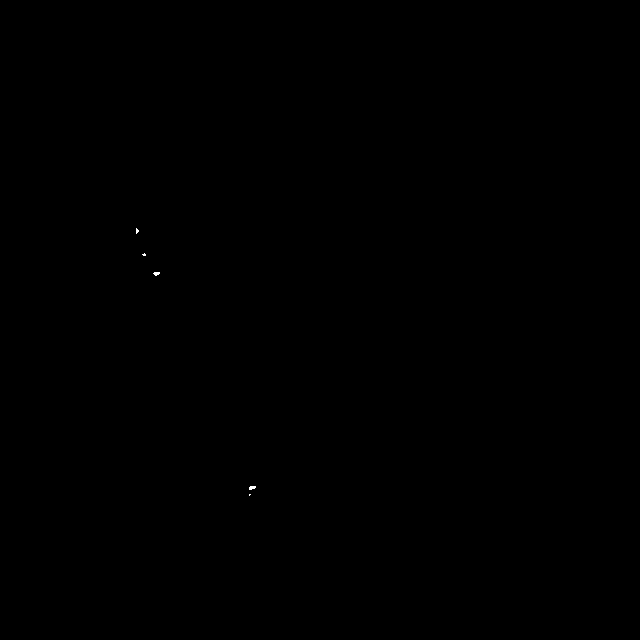

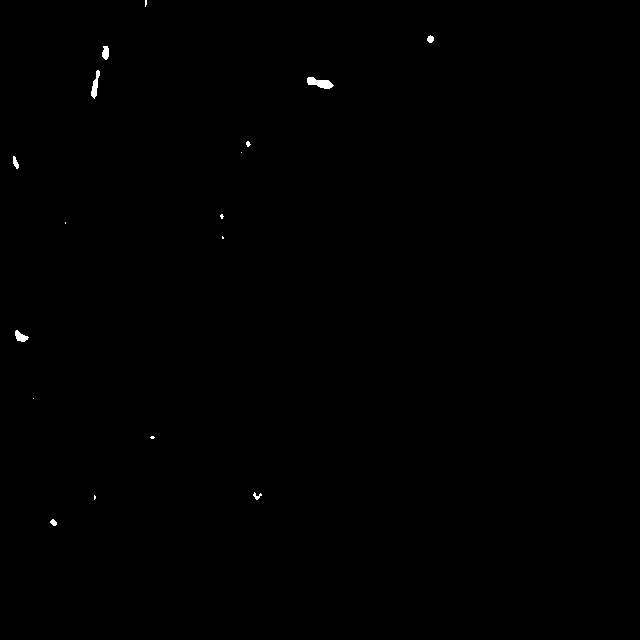

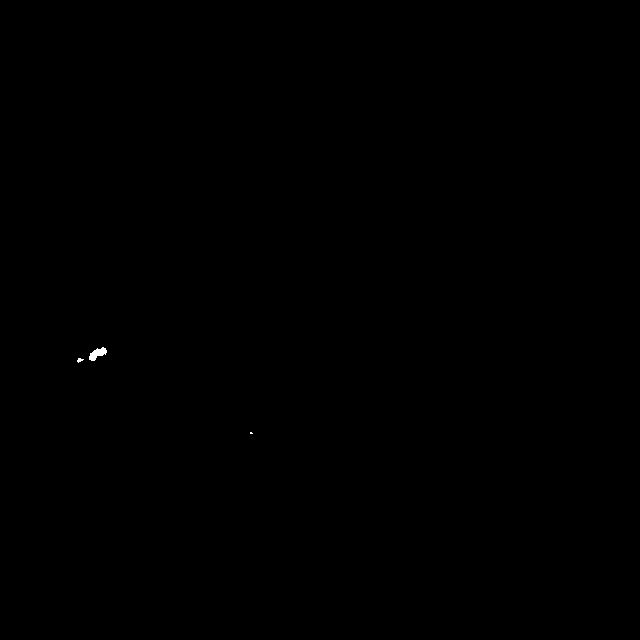

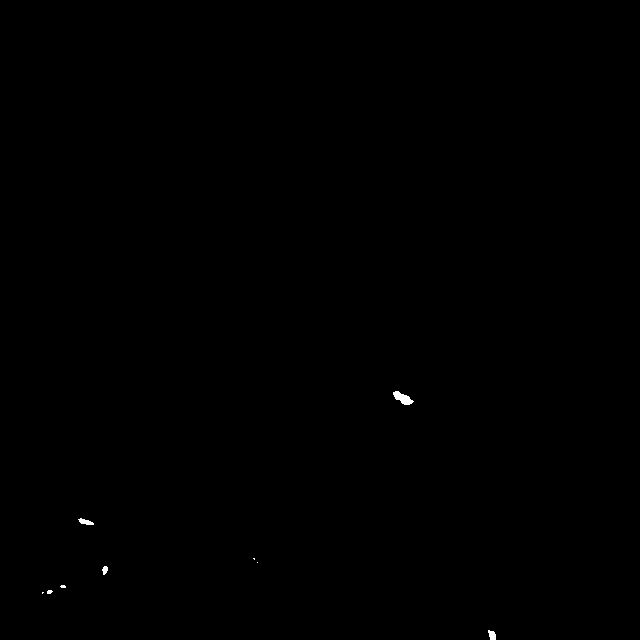

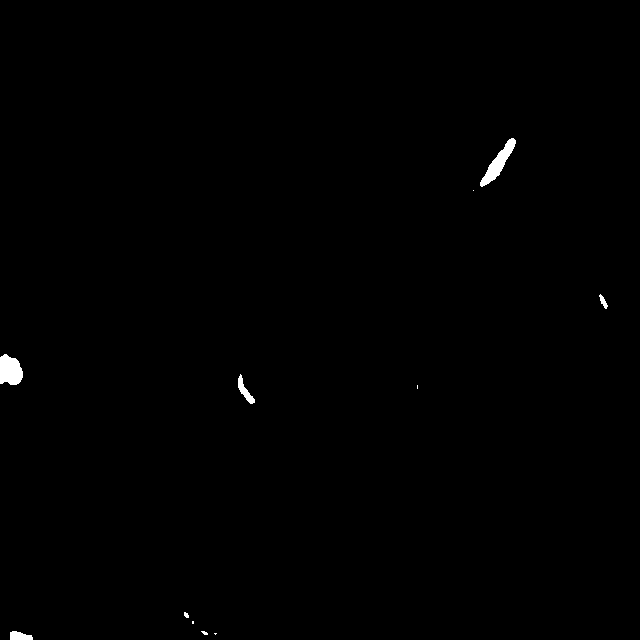

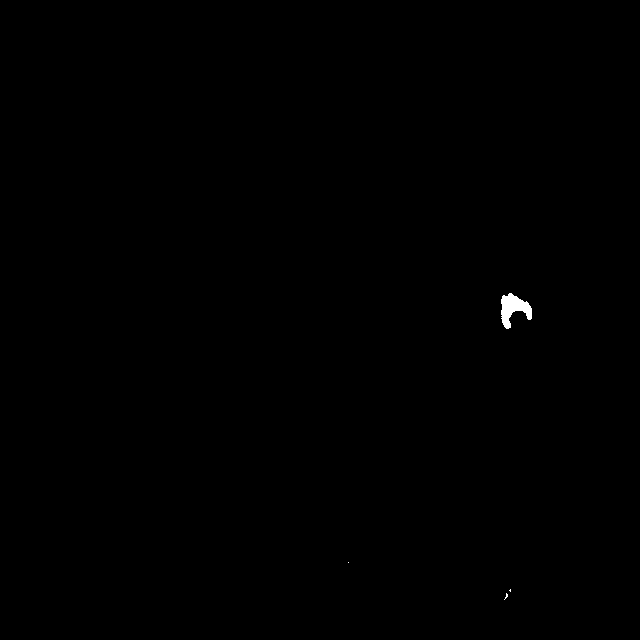

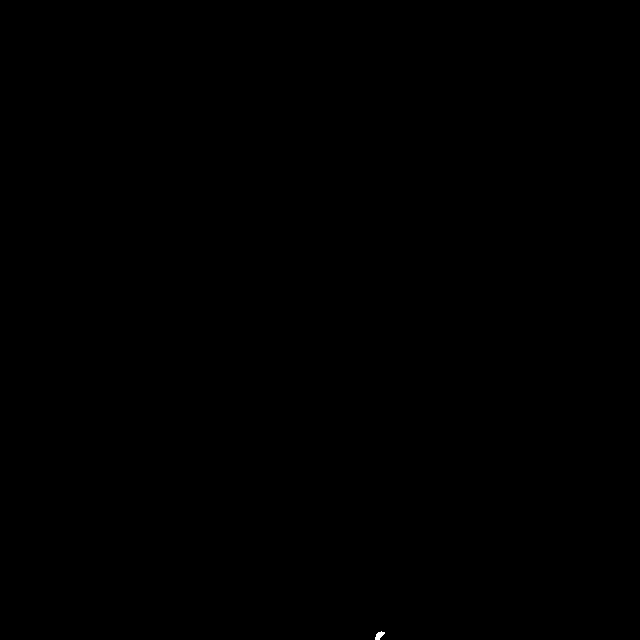

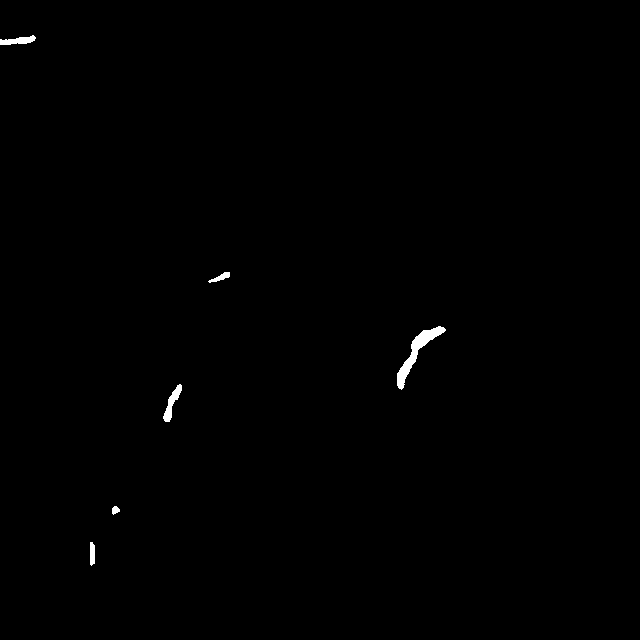

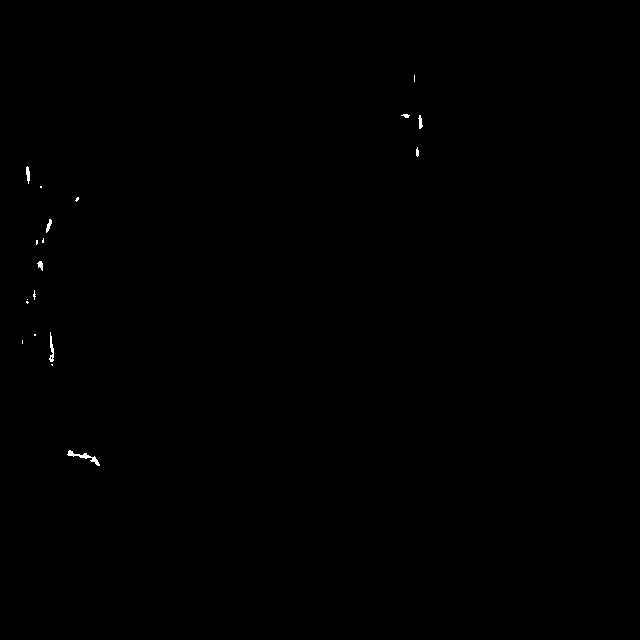

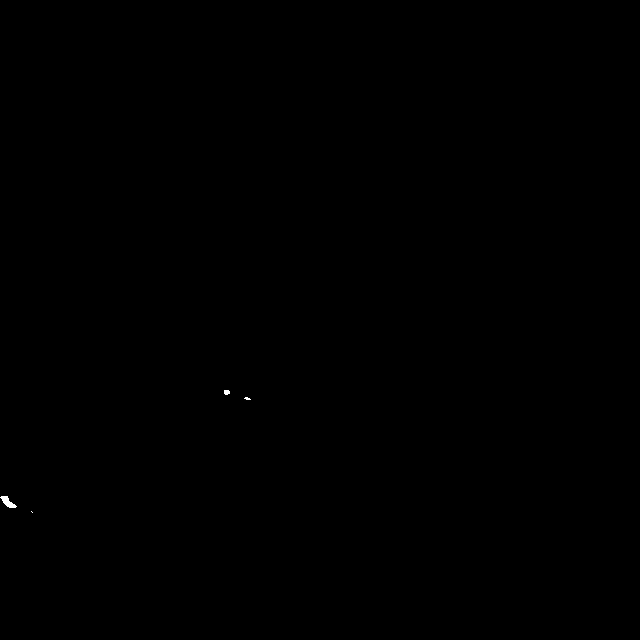

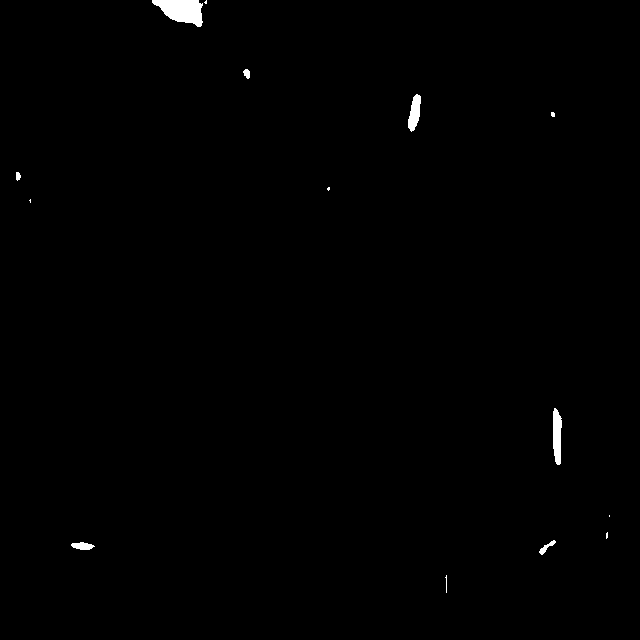

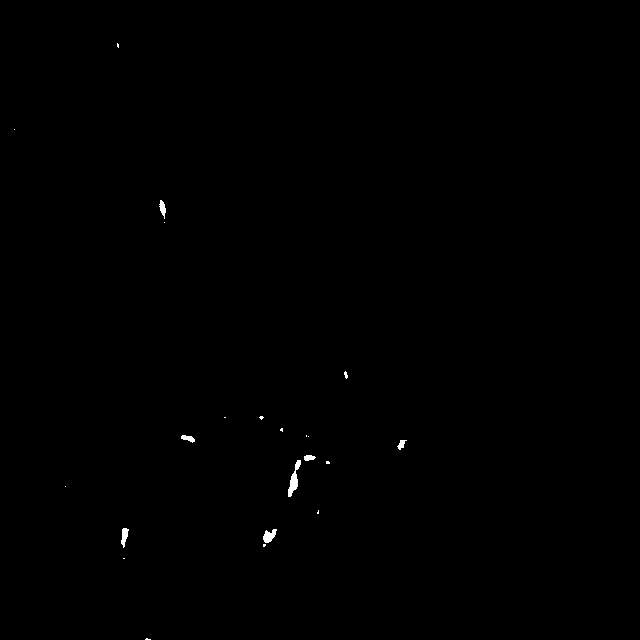

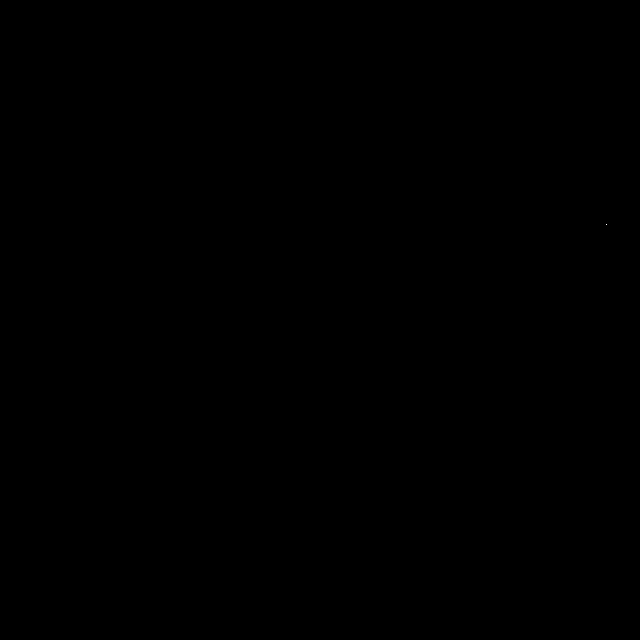

In [11]:
X_val = []
y_val = []
img_files = os.listdir(main_fold1)
for img_file in img_files:
  # print(cv2.imread(img_file))
  img_file_path = os.path.join(main_fold1, img_file)
  orig_img = cv2.imread(img_file_path)
  # cv2_imshow(orig_img)
  img = orig_img.copy()
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, img_th = cv2.threshold(img_gray,30,255,cv2.THRESH_BINARY_INV)
  img_th_inv = 255-img_th
  # a = image.img_to_array(orig_img)

  # # Performing image segmentation on input image
  img_seg = image_segmentation(orig_img)
  cv2_imshow(img_seg)
  # # Bitwise AND between segmented image and grayscale thresholded image to remove any bounding markers
  img_seg = cv2.bitwise_and(img_seg,img_th_inv)

  # # Resizing the segmented image to standard size of 600x800 for further processing
  img_seg = cv2.resize(img_seg,(img_shape[1],img_shape[0]))


  # # Post processing on the segmented image
  img_mask = image_postprocess(img_seg)
  # img_mask1=image.img_to_array(img_mask)
  #    # Save the mask image (optional)
  # mask_path = os.path.join(output_dir1, os.path.basename(img_file_path))
  # cv2.imwrite(mask_path, img_mask)

  # # Add the input image and mask image pair to the dataset
  X_val.append(img)
  y_val.append(img_mask)

In [ ]:
X_val = np.array(X_val)
y_val= np.array(y_val)


In [ ]:
# # unet = arcgis.learn.UnetClassifier(data, backbone=None, pretrained_path=None)
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import binary_crossentropy
# from sklearn.model_selection import train_test_split
# # Define the U-Net model architecture
# def unet_model(input_shape=(640, 640, 3)):
#     inputs = Input(input_shape)

#     # Encoder
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     # Bridge
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

#     # Decoder
#     up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
#     conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
#     conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

#     up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
#     conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
#     conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

#     up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
#     conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
#     conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

#     # Output layer
#     outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model




In [ ]:
# !pip install arcpy

In [ ]:
# import arcpy

In [ ]:
# # Define loss function and optimizer
# model = unet_model()
# model.compile(optimizer=Adam(), loss=binary_crossentropy)

# # Train the model
# model.fit(X_train, y_train, batch_size=10, epochs=10, validation_data=(X_val, y_val))

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [ ]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(640,640,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

In [ ]:
!pip install pydot

In [ ]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")

In [ ]:
# NUM_EPOCHS = 20
# BATCH_SIZE = 32
# # TRAIN_LENGTH = info.splits["train"].num_examples
# TRAIN_LENGTH = 200
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# VAL_SUBSPLITS = 5
# TEST_LENTH = 30
# VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

# model_history = unet_model.fit(X_train,y_train,
#                                epochs=NUM_EPOCHS,
#                                steps_per_epoch=STEPS_PER_EPOCH,
#                                validation_steps=VALIDATION_STEPS,
#                                validation_data=(X_val, y_val))

In [ ]:
# X_train.shape
X_val.shape

In [ ]:
# !pip install tensorflow-gpu==2.10.0


In [ ]:
unet_model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_val, y_val))